# Illustration of JAX-cosmo on a DES Y1-like analysis

In [1]:
%pylab inline
import os.path
import jax
import jax.numpy as np
import jax_cosmo as jc
import numpy as onp

Populating the interactive namespace from numpy and matplotlib


## Retrieving  the nz data

In [2]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)
nz_lens=fits.getdata('2pt_NG_mcal_1110.fits', 7)

Text(0.5, 0, 'z')

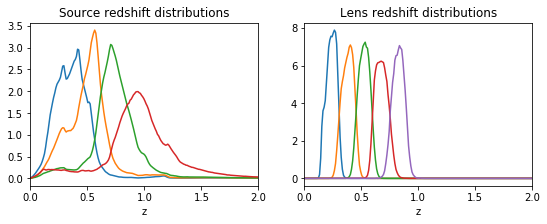

In [3]:
# Let's plot the NZs
figure(figsize=(9,3))
subplot(121)
plot(nz_source['Z_MID'], nz_source['BIN1'])
plot(nz_source['Z_MID'], nz_source['BIN2'])
plot(nz_source['Z_MID'], nz_source['BIN3'])
plot(nz_source['Z_MID'], nz_source['BIN4'])
xlim(0,2);
xlabel('z')
title('Source redshift distributions')
subplot(122)
plot(nz_lens['Z_MID'], nz_lens['BIN1'])
plot(nz_lens['Z_MID'], nz_lens['BIN2'])
plot(nz_lens['Z_MID'], nz_lens['BIN3'])
plot(nz_lens['Z_MID'], nz_lens['BIN4'])
plot(nz_lens['Z_MID'], nz_lens['BIN5'])
xlim(0,2);
title('Lens redshift distributions');
xlabel('z')

In [4]:
# Now let's try to build the equivalent with jax-cosmo

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]

nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]

nzs_l = [jc.redshift.kde_nz(nz_lens['Z_MID'].astype('float32'),
                              nz_lens['BIN%d'%i].astype('float32'), bw=0.01)
           for i in range(1,6)]

/usr/local/lib/python3.7/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


(0, 1)

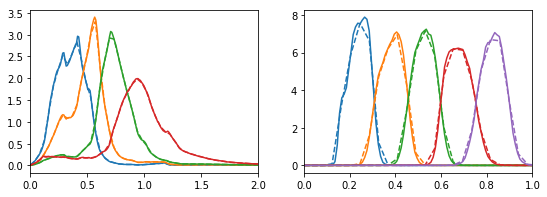

In [5]:
z = linspace(0,2)
figure(figsize=(9,3))
subplot(121)

for i in range(4):
    plot(nz_source['Z_MID'], nz_source['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_s[i](z), '--', color='C%d'%i)

xlim(0,2)
subplot(122)

for i in range(5):
    plot(nz_lens['Z_MID'], nz_lens['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_l[i](z), '--', color='C%d'%i)
xlim(0,1)

##  Let's build  a model for C_ell

In [6]:
# First, let's define a function to go to and from a 1d parameter vector
def get_params_vec(cosmo, m, dz, ia, bias):
    m1, m2, m3, m4 = m
    dz1, dz2, dz3, dz4 = dz
    A, eta = ia
    b1, b2, b3, b4, b5 = bias
    return np.array([ 
        # Cosmological parameters
        cosmo.sigma8, cosmo.Omega_c, cosmo.Omega_b,
        cosmo.h, cosmo.n_s, cosmo.w0,
        # Shear systematics
        m1, m2, m3, m4,
        # Photoz systematics
        dz1, dz2, dz3, dz4,
        # IA model
        A, eta,
        # linear galaxy bias
        b1, b2, b3, b4, b5
    ])
    
def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=params[0], Omega_c=params[1], Omega_b=params[2],
                         h=params[3], n_s=params[4], w0=params[5],
                         Omega_k=0., wa=0.)
    m1,m2,m3,m4 = params[6:10]
    dz1,dz2,dz3,dz4 = params[10:14]
    A = params[14]
    eta = params[15]
    bias = params[16:21]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta], bias

# Let's try a round trip just to make sure
p = get_params_vec(jc.Planck15(), [1.,2.,3.,4.], [5.,6.,7.,8.],
              [1., 2.], [1.2, 1.4, 1.6, 1.8, 2.0])
unpack_params_vec(p)

(Cosmological parameters: 
     h:        0.6774 
     Omega_b:  0.0486 
     Omega_c:  0.2589 
     Omega_k:  0.0 
     w0:       -1.0 
     wa:       0.0 
     n:        0.9667 
     sigma8:   0.8159,
 [1.0, 2.0, 3.0, 4.0],
 [5.0, 6.0, 7.0, 8.0],
 [DeviceArray(1., dtype=float32), DeviceArray(2., dtype=float32)],
 DeviceArray([1.2, 1.4, 1.6, 1.8, 2. ], dtype=float32))

In [7]:
# Define some ell range
ell = np.logspace(1, 3)

@jax.jit
def mu(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta), bias = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias] 

    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]
    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl

/usr/local/lib/python3.7/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/usr/local/lib/python3.7/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [8]:
# Let's try it out
fid_cosmo = jc.Cosmology(sigma8=0.801,
                          Omega_c=0.2545,
                          Omega_b=0.0485,
                          h=0.682,
                          n_s=0.971,
                          w0=-1., Omega_k=0., wa=0.)

fid_params = get_params_vec(fid_cosmo, 
                            [0., 0., 0., 0.],
                            [0., 0., 0., 0.],
                            [0.5, 0.],
                            [1.2, 1.4, 1.6, 1.8, 2.0])

In [9]:
cl_3x2pt = mu(fid_params)

/usr/local/lib/python3.7/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [10]:
## Building a Fisher matrix, we just need the covarianc
@jax.jit
def cov(params):
    
    cl_signal = mu(params)
    
    # First unpack parameter vector
    cosmo, m, dz, (A, eta), bias = unpack_params_vec(params) 
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias]
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]
    
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=0.25)
    
    return cov

In [11]:
C = cov(fid_params)

In [12]:
jacobian = jax.jit(jax.jacfwd(lambda p: mu(p).flatten()))

In [13]:
j = jacobian(fid_params)

In [14]:
import scipy

def symmetrized_matrix(U):
    u"""Return a new matrix like `U`, but with upper-triangle elements copied to lower-triangle ones."""
    M = U.copy()
    inds = onp.triu_indices_from(M,k=1)
    M[(inds[1], inds[0])] = M[inds]
    return M



def symmetric_positive_definite_inverse(M):
    u"""Compute the inverse of a symmetric positive definite matrix `M`.

    A :class:`ValueError` will be thrown if the computation cannot be
    completed.

    """
    import scipy.linalg
    U,status = scipy.linalg.lapack.dpotrf(M)
    if status != 0:
        raise ValueError("Non-symmetric positive definite matrix")
    M,status = scipy.linalg.lapack.dpotri(U)
    if status != 0:
        raise ValueError("Error in Cholesky factorization")
    M = symmetrized_matrix(M)
    return M

In [15]:
j64 = onp.array(j).astype(onp.float64)
C64 = onp.array(C).astype(onp.float64)

In [16]:
# And we get the fisher matrix from the jacobian and covariance
CC = symmetric_positive_definite_inverse(C64)
F = onp.einsum('ia,ij,jb->ab', j64, CC, j64)
F = 0.5*(F + F.T)

In [17]:
cov_estimate = symmetric_positive_definite_inverse(F)
onp.savetxt('cov_estimate_from_fisher.txt', cov_estimate)


In [17]:
def is_symmetric(X):
    return onp.all(X == X.T)

is_symmetric(F)

True

In [26]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, i, j, nstd=1., ax=None, resize=False, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[:,[i,j]][[i,j],:]
  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  xy = [pos[i], pos[j]]
  ellip = Ellipse(xy=xy, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  if resize:
    sz = max(width, height)
    s1 = 1.5*nstd*sigma_marg(i)
    s2 = 1.5*nstd*sigma_marg(j)
    ax.set_xlim(pos[i] - s1, pos[i] + s1)
    ax.set_ylim(pos[j] - s2, pos[j] + s2)
  plt.draw()
  return ellip

In [19]:
fid_params

DeviceArray([ 0.801 ,  0.2545,  0.0485,  0.682 ,  0.971 , -1.    ,
              0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
              0.    ,  0.    ,  0.5   ,  0.    ,  1.2   ,  1.4   ,
              1.6   ,  1.8   ,  2.    ], dtype=float32)

In [29]:
names = [
    "sigma8",
    "Omega_c",
    "Omega_b",
    "h",
    "n_s",
    "w0",
    "m1",
    "m2",
    "m3",
    "m4",
    "dz1",
    "dz2",
    "dz3",
    "dz4",
    "A",
    "eta",
    "b1",
    "b2",
    "b3",
    "b4",
    "b5",
]

/usr/local/lib/python3.7/site-packages/jax/lax/lax.py:5605: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


(1.5, 2)

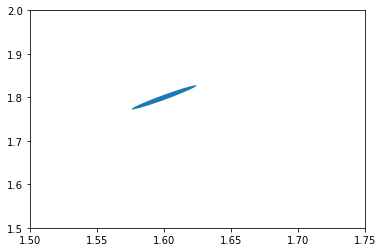

In [20]:
plot_contours(F, fid_params, 18, 19)
xlim(1.5, 1.75)
ylim(1.5, 2)

In [21]:
# parameter inverse mass matrix
M_inv = symmetric_positive_definite_inverse(F)
is_symmetric(M_inv)

True

In [22]:
#priors - index, mean, std. dev
prior_values = [
    (6, 0.012, 0.023),  #m1
    (7, 0.012, 0.023),  #m2
    (8, 0.012, 0.023),  #m3
    (9, 0.012, 0.023),  #m4
    (10, -0.001, 0.016),   #dz1
    (11, -0.019, 0.013),   #dz2
    (12,0.009, 0.011),   #dz3
    (13, -0.018, 0.022),   #dz4
]

In [39]:
def priors(p):
    logpi = 0.0
    dlogpi_dp = onp.zeros_like(p)
    for i, mu_i, sigma_i in prior_values:
        logpi += -0.5 * (p[i] - mu_i)**2 / sigma_i**2
        dlogpi_dp[i] = - (p[i] - mu_i) / sigma_i**2
    return logpi, dlogpi_dp

# returns -posterior P and -dL/dP
def fun(p, inv_cov=C, data=cl_3x2pt.flatten()):
    # theory C_ell prediction
    cl = mu(p).flatten()
    # d C_ell / d p
    j = jacobian(p).T
    d = cl - data
    dlogL_dCl = -inv_cov @ d
    logL = 0.5 * d @ dlogL_dCl
    dlogL_dp = j @ dlogL_dCl
    
    # Add Gaussian priors.
    # Can't use += because of JAX
    logPi, dlogPi_dp = priors(p)
    P = logL + logPi
    dP_dp = dlogL_dp + dlogPi_dp

    # convert back to regular numpy arrays
    return onp.array(P), onp.array(dP_dp)


In [57]:
import hmc
importlib.reload(hmc)
onp.random.seed(100)
limits = [
    (0.5, 0.9), # sigma8
    (0.1, 0.5), # Omega_c
    (0.03, 0.06), # Omega_b
    (0.5,  0.9), # h
    (0.9,  1.05), # n_s
    (-2.0,  -0.5), # w0
    (-0.06, 0.06), #m1
    (-0.06, 0.06), #m2
    (-0.06, 0.06), #m3
    (-0.06, 0.06), #m4
    (-0.1, 0.1), #dz1
    (-0.1, 0.1), #dz2
    (-0.1, 0.1), #dz3
    (-0.1, 0.1), #dz4
    (0.0, 3.0),  #A
    (-3., 3.), #eta
    (0.8, 3.0), #bias1
    (0.8, 3.0), #bias2
    (0.8, 3.0), #bias3
    (0.8, 3.0), #bias4
    (0.8, 3.0), #bias5
]
data = onp.array(cl_3x2pt.flatten())
Cinv = onp.linalg.inv(C)
epsilon = 0.02 # time step
steps_per_iteration = 25
fun_kwargs = {'inv_cov': Cinv, 'data': data} 
sampler = hmc.HMC(fun, M_inv, epsilon, steps_per_iteration, limits, kwargs=fun_kwargs)
n_it = 1000
sampler.sample(n_it, fid_params)

U=2.319   T=7.151   H=9.470   ΔH=0.000
U=2.358   T=7.116   H=9.474   ΔH=0.005
U=2.396   T=7.080   H=9.476   ΔH=0.007
U=2.439   T=7.044   H=9.484   ΔH=0.014
U=2.481   T=7.008   H=9.489   ΔH=0.019
U=2.525   T=6.970   H=9.495   ΔH=0.025
U=2.595   T=6.931   H=9.526   ΔH=0.057
U=2.640   T=6.891   H=9.531   ΔH=0.062
U=2.693   T=6.849   H=9.543   ΔH=0.073
U=2.747   T=6.805   H=9.552   ΔH=0.082
U=2.817   T=6.757   H=9.574   ΔH=0.104
U=2.915   T=6.705   H=9.620   ΔH=0.151
U=2.983   T=6.649   H=9.631   ΔH=0.162
U=3.053   T=6.587   H=9.640   ΔH=0.170
U=3.134   T=6.519   H=9.653   ΔH=0.184
U=3.247   T=6.444   H=9.691   ΔH=0.222
U=3.395   T=6.363   H=9.758   ΔH=0.288
U=3.511   T=6.274   H=9.785   ΔH=0.315
U=3.635   T=6.177   H=9.812   ΔH=0.342
U=3.744   T=6.071   H=9.815   ΔH=0.346
U=3.911   T=5.956   H=9.868   ΔH=0.398
U=4.066   T=5.833   H=9.899   ΔH=0.430
U=4.246   T=5.703   H=9.949   ΔH=0.480
U=4.388   T=5.563   H=9.952   ΔH=0.482
U=4.596   T=5.416   H=10.012   ΔH=0.542
Accept 0 alpha=0.58  p=0

U=6.563   T=11.322   H=17.885   ΔH=0.644
U=6.811   T=11.146   H=17.958   ΔH=0.717
U=7.049   T=10.949   H=17.998   ΔH=0.757
U=7.314   T=10.731   H=18.046   ΔH=0.805
Reject 7 alpha=0.45  p=0.95
U=6.313   T=10.019   H=16.332   ΔH=0.022
U=6.520   T=9.820   H=16.340   ΔH=0.030
U=6.718   T=9.625   H=16.343   ΔH=0.033
U=6.918   T=9.440   H=16.358   ΔH=0.048
U=7.095   T=9.270   H=16.365   ΔH=0.055
U=7.255   T=9.123   H=16.378   ΔH=0.068
U=7.418   T=9.002   H=16.420   ΔH=0.110
U=7.512   T=8.912   H=16.424   ΔH=0.114
U=7.573   T=8.854   H=16.426   ΔH=0.116
U=7.633   T=8.831   H=16.463   ΔH=0.154
U=7.623   T=8.845   H=16.468   ΔH=0.158
U=7.579   T=8.896   H=16.475   ΔH=0.165
U=7.493   T=8.983   H=16.476   ΔH=0.166
U=7.381   T=9.104   H=16.485   ΔH=0.175
U=7.245   T=9.257   H=16.502   ΔH=0.192
U=7.087   T=9.440   H=16.526   ΔH=0.216
U=6.894   T=9.648   H=16.542   ΔH=0.232
U=6.668   T=9.875   H=16.543   ΔH=0.233
U=6.427   T=10.116   H=16.543   ΔH=0.233
U=6.183   T=10.364   H=16.547   ΔH=0.237
U=5.9

U=18.987   T=14.168   H=33.154   ΔH=-0.102
U=18.578   T=14.584   H=33.163   ΔH=-0.093
U=18.172   T=14.997   H=33.169   ΔH=-0.087
U=17.776   T=15.396   H=33.172   ΔH=-0.085
U=17.357   T=15.768   H=33.126   ΔH=-0.130
U=17.026   T=16.107   H=33.133   ΔH=-0.123
U=16.764   T=16.406   H=33.170   ΔH=-0.086
U=16.494   T=16.660   H=33.154   ΔH=-0.102
U=16.345   T=16.864   H=33.209   ΔH=-0.047
U=16.208   T=17.016   H=33.224   ΔH=-0.032
U=16.168   T=17.115   H=33.283   ΔH=0.027
U=16.114   T=17.158   H=33.272   ΔH=0.016
U=16.195   T=17.149   H=33.343   ΔH=0.087
Reject 15 alpha=0.92  p=0.96
U=21.104   T=6.106   H=27.210   ΔH=0.027
U=21.621   T=5.626   H=27.247   ΔH=0.064
U=22.031   T=5.227   H=27.258   ΔH=0.075
U=22.340   T=4.918   H=27.257   ΔH=0.074
U=22.546   T=4.707   H=27.253   ΔH=0.070
U=22.655   T=4.599   H=27.254   ΔH=0.071
U=22.654   T=4.599   H=27.253   ΔH=0.070
U=22.548   T=4.707   H=27.255   ΔH=0.073
U=22.337   T=4.922   H=27.259   ΔH=0.076
U=22.019   T=5.241   H=27.260   ΔH=0.077
U=21.

U=10.938   T=17.762   H=28.700   ΔH=0.018
U=11.023   T=17.683   H=28.705   ΔH=0.023
U=11.110   T=17.593   H=28.703   ΔH=0.021
U=11.212   T=17.494   H=28.705   ΔH=0.023
U=11.320   T=17.387   H=28.707   ΔH=0.025
U=11.434   T=17.274   H=28.708   ΔH=0.026
U=11.546   T=17.157   H=28.703   ΔH=0.021
U=11.663   T=17.038   H=28.701   ΔH=0.019
U=11.776   T=16.919   H=28.694   ΔH=0.012
U=11.891   T=16.801   H=28.692   ΔH=0.010
U=12.001   T=16.687   H=28.688   ΔH=0.006
U=12.073   T=16.578   H=28.651   ΔH=-0.031
U=12.159   T=16.477   H=28.636   ΔH=-0.046
U=12.247   T=16.383   H=28.630   ΔH=-0.052
U=12.325   T=16.299   H=28.624   ΔH=-0.058
U=12.348   T=16.225   H=28.573   ΔH=-0.109
U=12.389   T=16.162   H=28.551   ΔH=-0.131
U=12.411   T=16.111   H=28.522   ΔH=-0.161
U=12.403   T=16.071   H=28.474   ΔH=-0.208
Accept 23 alpha=1.23  p=1.00
U=12.429   T=8.294   H=20.723   ΔH=0.048
U=12.427   T=8.327   H=20.754   ΔH=0.079
U=12.422   T=8.371   H=20.793   ΔH=0.118
U=12.402   T=8.425   H=20.827   ΔH=0.152
U

U=16.094   T=6.633   H=22.728   ΔH=-0.007
U=15.943   T=6.785   H=22.728   ΔH=-0.007
U=15.781   T=6.946   H=22.727   ΔH=-0.007
Accept 30 alpha=1.01  p=0.17
U=15.737   T=12.317   H=28.055   ΔH=0.011
U=15.616   T=12.368   H=27.983   ΔH=-0.061
U=15.521   T=12.414   H=27.935   ΔH=-0.109
U=15.498   T=12.455   H=27.953   ΔH=-0.091
U=15.338   T=12.491   H=27.830   ΔH=-0.214
U=15.278   T=12.523   H=27.802   ΔH=-0.242
U=15.178   T=12.552   H=27.730   ΔH=-0.314
U=15.133   T=12.583   H=27.716   ΔH=-0.327
U=14.953   T=12.614   H=27.567   ΔH=-0.477
U=14.894   T=12.643   H=27.537   ΔH=-0.507
U=14.773   T=12.677   H=27.450   ΔH=-0.594
U=14.705   T=12.716   H=27.421   ΔH=-0.622
U=14.529   T=12.758   H=27.287   ΔH=-0.757
U=14.360   T=12.802   H=27.162   ΔH=-0.882
U=14.297   T=12.853   H=27.150   ΔH=-0.893
U=14.101   T=12.911   H=27.011   ΔH=-1.032
U=14.001   T=12.975   H=26.977   ΔH=-1.067
U=13.784   T=13.047   H=26.831   ΔH=-1.213
U=13.679   T=13.125   H=26.804   ΔH=-1.240
U=13.481   T=13.212   H=26.69

U=11.824   T=12.668   H=24.491   ΔH=-0.006
U=11.915   T=12.577   H=24.492   ΔH=-0.006
U=11.994   T=12.498   H=24.492   ΔH=-0.006
U=12.060   T=12.432   H=24.492   ΔH=-0.006
U=12.155   T=12.378   H=24.533   ΔH=0.036
U=12.199   T=12.337   H=24.535   ΔH=0.038
U=12.229   T=12.306   H=24.534   ΔH=0.037
U=12.250   T=12.284   H=24.534   ΔH=0.037
U=12.264   T=12.271   H=24.535   ΔH=0.037
U=12.270   T=12.265   H=24.535   ΔH=0.037
U=12.271   T=12.263   H=24.534   ΔH=0.037
U=12.275   T=12.264   H=24.539   ΔH=0.042
U=12.272   T=12.267   H=24.539   ΔH=0.041
U=12.269   T=12.269   H=24.538   ΔH=0.041
U=12.269   T=12.270   H=24.539   ΔH=0.041
Accept 38 alpha=0.96  p=0.77
U=12.335   T=7.463   H=19.798   ΔH=0.000
U=12.391   T=7.407   H=19.798   ΔH=0.000
U=12.436   T=7.362   H=19.798   ΔH=0.000
U=12.469   T=7.329   H=19.798   ΔH=0.001
U=12.490   T=7.308   H=19.798   ΔH=0.000
U=12.498   T=7.299   H=19.798   ΔH=0.000
U=12.467   T=7.303   H=19.770   ΔH=-0.028
U=12.464   T=7.319   H=19.783   ΔH=-0.014
U=12.43

U=8.132   T=10.549   H=18.681   ΔH=-0.002
U=8.533   T=10.183   H=18.716   ΔH=0.032
U=8.924   T=9.793   H=18.717   ΔH=0.033
U=9.330   T=9.383   H=18.713   ΔH=0.029
U=9.755   T=8.959   H=18.713   ΔH=0.029
U=10.187   T=8.526   H=18.713   ΔH=0.029
U=10.619   T=8.091   H=18.710   ΔH=0.026
U=11.081   T=7.660   H=18.742   ΔH=0.058
U=11.509   T=7.239   H=18.748   ΔH=0.064
U=11.915   T=6.834   H=18.749   ΔH=0.065
U=12.301   T=6.449   H=18.750   ΔH=0.066
U=12.659   T=6.092   H=18.751   ΔH=0.067
U=12.986   T=5.765   H=18.750   ΔH=0.066
U=13.278   T=5.473   H=18.751   ΔH=0.067
U=13.532   T=5.219   H=18.751   ΔH=0.067
U=13.706   T=5.006   H=18.711   ΔH=0.027
U=13.877   T=4.834   H=18.711   ΔH=0.027
U=14.005   T=4.706   H=18.711   ΔH=0.027
U=14.091   T=4.619   H=18.711   ΔH=0.027
U=14.132   T=4.574   H=18.706   ΔH=0.022
U=14.133   T=4.567   H=18.700   ΔH=0.016
U=14.125   T=4.596   H=18.721   ΔH=0.037
U=14.076   T=4.657   H=18.733   ΔH=0.049
Accept 46 alpha=0.95  p=0.08
U=13.701   T=10.849   H=24.550

U=7.262   T=9.770   H=17.031   ΔH=0.162
U=7.119   T=9.922   H=17.041   ΔH=0.171
U=6.989   T=10.073   H=17.062   ΔH=0.193
U=6.845   T=10.223   H=17.068   ΔH=0.198
Accept 53 alpha=0.82  p=0.56
U=6.843   T=6.982   H=13.826   ΔH=0.002
U=6.835   T=6.992   H=13.827   ΔH=0.003
U=6.829   T=7.009   H=13.838   ΔH=0.014
U=6.820   T=7.030   H=13.850   ΔH=0.026
U=6.798   T=7.056   H=13.854   ΔH=0.030
U=6.773   T=7.086   H=13.860   ΔH=0.036
U=6.789   T=7.120   H=13.910   ΔH=0.086
U=6.767   T=7.158   H=13.925   ΔH=0.101
U=6.741   T=7.196   H=13.938   ΔH=0.114
U=6.712   T=7.235   H=13.947   ΔH=0.123
U=6.685   T=7.272   H=13.957   ΔH=0.133
U=6.654   T=7.307   H=13.960   ΔH=0.136
U=6.622   T=7.338   H=13.960   ΔH=0.136
U=6.612   T=7.364   H=13.976   ΔH=0.152
U=6.603   T=7.385   H=13.988   ΔH=0.164
U=6.625   T=7.398   H=14.023   ΔH=0.199
U=6.619   T=7.404   H=14.023   ΔH=0.199
U=6.647   T=7.402   H=14.049   ΔH=0.225
U=6.686   T=7.391   H=14.077   ΔH=0.253
U=6.740   T=7.370   H=14.110   ΔH=0.286
U=6.813  

U=9.606   T=15.737   H=25.342   ΔH=0.056
U=9.675   T=15.667   H=25.342   ΔH=0.056
U=9.747   T=15.591   H=25.339   ΔH=0.052
U=9.830   T=15.507   H=25.337   ΔH=0.051
U=9.974   T=15.411   H=25.385   ΔH=0.098
U=10.111   T=15.298   H=25.409   ΔH=0.123
U=10.255   T=15.168   H=25.423   ΔH=0.137
U=10.407   T=15.017   H=25.424   ΔH=0.138
U=10.651   T=14.843   H=25.494   ΔH=0.207
U=10.907   T=14.644   H=25.551   ΔH=0.264
Accept 61 alpha=0.77  p=0.53
U=10.863   T=12.153   H=23.016   ΔH=-0.002
U=10.814   T=12.176   H=22.990   ΔH=-0.028
U=10.786   T=12.179   H=22.965   ΔH=-0.053
U=10.806   T=12.159   H=22.966   ΔH=-0.052
U=10.834   T=12.119   H=22.952   ΔH=-0.066
U=10.895   T=12.056   H=22.951   ΔH=-0.067
U=10.980   T=11.972   H=22.952   ΔH=-0.066
U=11.088   T=11.868   H=22.955   ΔH=-0.063
U=11.208   T=11.745   H=22.953   ΔH=-0.065
U=11.348   T=11.605   H=22.952   ΔH=-0.066
U=11.506   T=11.450   H=22.956   ΔH=-0.062
U=11.673   T=11.284   H=22.957   ΔH=-0.061
U=11.851   T=11.108   H=22.959   ΔH=-0.0

U=17.767   T=4.562   H=22.329   ΔH=0.003
U=17.884   T=4.485   H=22.369   ΔH=0.043
U=18.008   T=4.415   H=22.424   ΔH=0.097
U=18.080   T=4.352   H=22.432   ΔH=0.106
U=18.140   T=4.297   H=22.437   ΔH=0.111
U=18.183   T=4.250   H=22.433   ΔH=0.107
U=18.298   T=4.212   H=22.510   ΔH=0.184
U=18.371   T=4.185   H=22.557   ΔH=0.231
U=18.422   T=4.169   H=22.591   ΔH=0.265
U=18.427   T=4.164   H=22.591   ΔH=0.265
U=18.526   T=4.171   H=22.697   ΔH=0.371
U=18.504   T=4.192   H=22.696   ΔH=0.370
U=18.504   T=4.226   H=22.731   ΔH=0.405
U=18.459   T=4.275   H=22.733   ΔH=0.407
U=18.433   T=4.337   H=22.769   ΔH=0.443
U=18.392   T=4.413   H=22.805   ΔH=0.479
U=18.337   T=4.503   H=22.839   ΔH=0.513
U=18.266   T=4.606   H=22.872   ΔH=0.546
U=18.173   T=4.723   H=22.896   ΔH=0.570
U=18.095   T=4.853   H=22.947   ΔH=0.621
Reject 69 alpha=0.54  p=0.97
U=17.207   T=11.096   H=28.302   ΔH=0.008
U=17.182   T=11.126   H=28.308   ΔH=0.013
U=17.120   T=11.136   H=28.257   ΔH=-0.038
U=17.218   T=11.131   H=

U=12.601   T=10.783   H=23.384   ΔH=-0.035
U=12.668   T=10.696   H=23.364   ΔH=-0.056
U=12.762   T=10.601   H=23.363   ΔH=-0.056
U=12.857   T=10.500   H=23.357   ΔH=-0.063
Accept 76 alpha=1.06  p=0.97
U=12.811   T=10.054   H=22.865   ΔH=-0.022
U=12.788   T=10.056   H=22.844   ΔH=-0.043
U=12.786   T=10.035   H=22.821   ΔH=-0.065
U=12.828   T=9.994   H=22.822   ΔH=-0.065
U=12.889   T=9.934   H=22.822   ΔH=-0.064
U=12.965   T=9.857   H=22.821   ΔH=-0.065
U=13.061   T=9.765   H=22.826   ΔH=-0.060
U=13.163   T=9.663   H=22.826   ΔH=-0.060
U=13.252   T=9.554   H=22.806   ΔH=-0.080
U=13.363   T=9.442   H=22.805   ΔH=-0.082
U=13.464   T=9.328   H=22.792   ΔH=-0.094
U=13.574   T=9.219   H=22.793   ΔH=-0.094
U=13.681   T=9.119   H=22.800   ΔH=-0.087
U=13.784   T=9.031   H=22.815   ΔH=-0.072
U=13.860   T=8.958   H=22.818   ΔH=-0.069
U=13.916   T=8.904   H=22.820   ΔH=-0.067
U=13.965   T=8.868   H=22.834   ΔH=-0.053
U=13.998   T=8.854   H=22.851   ΔH=-0.035
U=13.989   T=8.862   H=22.851   ΔH=-0.03

U=13.093   T=8.653   H=21.747   ΔH=0.028
U=13.200   T=8.546   H=21.746   ΔH=0.027
U=13.301   T=8.446   H=21.747   ΔH=0.028
U=13.394   T=8.352   H=21.746   ΔH=0.027
U=13.480   T=8.266   H=21.746   ΔH=0.027
U=13.560   T=8.185   H=21.745   ΔH=0.027
U=13.634   T=8.112   H=21.746   ΔH=0.027
U=13.688   T=8.046   H=21.733   ΔH=0.015
U=13.748   T=7.985   H=21.734   ΔH=0.015
U=13.802   T=7.931   H=21.733   ΔH=0.014
U=13.851   T=7.882   H=21.733   ΔH=0.014
U=13.896   T=7.838   H=21.734   ΔH=0.015
U=13.933   T=7.799   H=21.732   ΔH=0.013
U=13.969   T=7.764   H=21.733   ΔH=0.014
U=14.010   T=7.733   H=21.742   ΔH=0.023
U=14.048   T=7.705   H=21.753   ΔH=0.034
U=14.070   T=7.680   H=21.750   ΔH=0.031
Accept 84 alpha=0.97  p=0.61
U=14.154   T=10.787   H=24.941   ΔH=-0.016
U=14.275   T=10.685   H=24.960   ΔH=0.003
U=14.382   T=10.581   H=24.963   ΔH=0.006
U=14.577   T=10.475   H=25.052   ΔH=0.095
U=14.664   T=10.370   H=25.034   ΔH=0.077
U=14.796   T=10.267   H=25.063   ΔH=0.106
U=14.977   T=10.169  

U=10.669   T=7.719   H=18.388   ΔH=-0.002
U=10.725   T=7.680   H=18.405   ΔH=0.016
U=10.761   T=7.651   H=18.412   ΔH=0.022
U=10.773   T=7.632   H=18.405   ΔH=0.016
U=10.781   T=7.624   H=18.405   ΔH=0.016
U=10.760   T=7.626   H=18.386   ΔH=-0.003
U=10.748   T=7.638   H=18.386   ΔH=-0.004
U=10.700   T=7.658   H=18.359   ΔH=-0.031
U=10.671   T=7.687   H=18.358   ΔH=-0.031
U=10.634   T=7.723   H=18.357   ΔH=-0.033
U=10.592   T=7.763   H=18.355   ΔH=-0.035
U=10.547   T=7.807   H=18.354   ΔH=-0.035
U=10.504   T=7.854   H=18.358   ΔH=-0.031
U=10.458   T=7.900   H=18.358   ΔH=-0.031
U=10.408   T=7.946   H=18.354   ΔH=-0.036
U=10.365   T=7.988   H=18.353   ΔH=-0.036
U=10.327   T=8.026   H=18.353   ΔH=-0.036
U=10.296   T=8.058   H=18.354   ΔH=-0.036
U=10.273   T=8.082   H=18.355   ΔH=-0.035
U=10.256   T=8.098   H=18.353   ΔH=-0.036
U=10.250   T=8.104   H=18.354   ΔH=-0.036
U=10.258   T=8.099   H=18.357   ΔH=-0.032
U=10.263   T=8.083   H=18.347   ΔH=-0.043
U=10.291   T=8.056   H=18.347   ΔH=-0.

U=12.642   T=11.013   H=23.655   ΔH=0.009
U=12.557   T=11.099   H=23.656   ΔH=0.011
U=12.478   T=11.178   H=23.656   ΔH=0.010
U=12.406   T=11.251   H=23.657   ΔH=0.011
U=12.340   T=11.316   H=23.656   ΔH=0.010
U=12.287   T=11.375   H=23.662   ΔH=0.017
U=12.239   T=11.427   H=23.666   ΔH=0.021
U=12.196   T=11.473   H=23.670   ΔH=0.024
Accept 99 alpha=0.98  p=0.65
U=12.118   T=12.164   H=24.282   ΔH=-0.061
U=12.045   T=12.178   H=24.223   ΔH=-0.120
U=12.024   T=12.187   H=24.211   ΔH=-0.131
U=11.984   T=12.193   H=24.176   ΔH=-0.166
U=11.941   T=12.196   H=24.137   ΔH=-0.205
U=11.883   T=12.197   H=24.080   ΔH=-0.262
U=11.802   T=12.193   H=23.995   ΔH=-0.347
U=11.799   T=12.185   H=23.984   ΔH=-0.359
U=11.838   T=12.174   H=24.012   ΔH=-0.330
U=11.826   T=12.161   H=23.988   ΔH=-0.355
U=11.732   T=12.145   H=23.876   ΔH=-0.466
U=11.694   T=12.125   H=23.819   ΔH=-0.524
U=11.658   T=12.102   H=23.759   ΔH=-0.583
U=11.661   T=12.076   H=23.737   ΔH=-0.605
U=11.645   T=12.048   H=23.693   

U=10.489   T=8.807   H=19.296   ΔH=-0.115
U=10.581   T=8.697   H=19.278   ΔH=-0.133
U=10.668   T=8.594   H=19.263   ΔH=-0.148
U=10.766   T=8.501   H=19.267   ΔH=-0.145
U=10.843   T=8.418   H=19.261   ΔH=-0.150
U=10.918   T=8.347   H=19.265   ΔH=-0.146
U=10.999   T=8.287   H=19.286   ΔH=-0.125
U=11.046   T=8.241   H=19.286   ΔH=-0.125
U=11.069   T=8.208   H=19.277   ΔH=-0.134
U=11.079   T=8.188   H=19.267   ΔH=-0.145
U=11.101   T=8.181   H=19.281   ΔH=-0.130
U=11.083   T=8.187   H=19.270   ΔH=-0.141
U=11.096   T=8.205   H=19.301   ΔH=-0.110
U=11.033   T=8.235   H=19.268   ΔH=-0.143
U=11.008   T=8.276   H=19.284   ΔH=-0.127
Accept 107 alpha=1.14  p=0.90
U=10.983   T=12.681   H=23.664   ΔH=0.009
U=10.992   T=12.692   H=23.684   ΔH=0.029
U=11.004   T=12.679   H=23.683   ΔH=0.028
U=11.058   T=12.640   H=23.699   ΔH=0.043
U=11.133   T=12.576   H=23.709   ΔH=0.054
U=11.223   T=12.484   H=23.706   ΔH=0.051
U=11.365   T=12.365   H=23.730   ΔH=0.075
U=11.532   T=12.222   H=23.754   ΔH=0.099
U=11

U=10.419   T=11.016   H=21.434   ΔH=-0.011
U=10.302   T=11.130   H=21.432   ΔH=-0.013
U=10.214   T=11.218   H=21.431   ΔH=-0.014
U=10.151   T=11.280   H=21.432   ΔH=-0.014
U=10.114   T=11.318   H=21.432   ΔH=-0.013
U=10.100   T=11.333   H=21.433   ΔH=-0.013
U=10.108   T=11.326   H=21.433   ΔH=-0.012
U=10.131   T=11.300   H=21.431   ΔH=-0.014
U=10.172   T=11.259   H=21.431   ΔH=-0.014
U=10.219   T=11.207   H=21.426   ΔH=-0.020
U=10.288   T=11.145   H=21.433   ΔH=-0.012
U=10.356   T=11.079   H=21.435   ΔH=-0.010
U=10.423   T=11.012   H=21.434   ΔH=-0.011
U=10.474   T=10.947   H=21.421   ΔH=-0.024
U=10.535   T=10.889   H=21.424   ΔH=-0.021
U=10.573   T=10.841   H=21.414   ΔH=-0.031
U=10.609   T=10.805   H=21.414   ΔH=-0.031
U=10.637   T=10.785   H=21.422   ΔH=-0.023
U=10.640   T=10.783   H=21.422   ΔH=-0.023
U=10.622   T=10.800   H=21.421   ΔH=-0.024
U=10.584   T=10.837   H=21.421   ΔH=-0.024
U=10.535   T=10.896   H=21.432   ΔH=-0.014
U=10.455   T=10.977   H=21.432   ΔH=-0.013
U=10.354   

U=10.028   T=6.444   H=16.472   ΔH=-0.047
U=9.994   T=6.477   H=16.471   ΔH=-0.048
U=9.951   T=6.514   H=16.465   ΔH=-0.054
U=9.908   T=6.557   H=16.465   ΔH=-0.054
U=9.861   T=6.603   H=16.465   ΔH=-0.054
U=9.817   T=6.655   H=16.472   ΔH=-0.047
U=9.721   T=6.709   H=16.430   ΔH=-0.089
U=9.665   T=6.767   H=16.432   ΔH=-0.087
Accept 122 alpha=1.09  p=0.08
U=9.840   T=8.741   H=18.581   ΔH=-0.002
U=10.039   T=8.566   H=18.605   ΔH=0.023
U=10.217   T=8.393   H=18.610   ΔH=0.027
U=10.391   T=8.223   H=18.614   ΔH=0.032
U=10.550   T=8.058   H=18.608   ΔH=0.025
U=10.681   T=7.900   H=18.580   ΔH=-0.002
U=10.835   T=7.749   H=18.584   ΔH=0.001
U=10.979   T=7.604   H=18.583   ΔH=0.001
U=11.118   T=7.466   H=18.584   ΔH=0.001
U=11.244   T=7.335   H=18.579   ΔH=-0.003
U=11.367   T=7.212   H=18.579   ΔH=-0.004
U=11.497   T=7.096   H=18.593   ΔH=0.010
U=11.608   T=6.987   H=18.595   ΔH=0.012
U=11.710   T=6.885   H=18.595   ΔH=0.012
U=11.820   T=6.790   H=18.610   ΔH=0.028
U=11.908   T=6.702   H=

U=9.842   T=12.414   H=22.257   ΔH=0.015
U=9.768   T=12.489   H=22.257   ΔH=0.015
U=9.711   T=12.547   H=22.257   ΔH=0.015
U=9.669   T=12.588   H=22.257   ΔH=0.015
U=9.643   T=12.614   H=22.257   ΔH=0.015
U=9.632   T=12.625   H=22.257   ΔH=0.015
U=9.632   T=12.624   H=22.257   ΔH=0.015
U=9.622   T=12.612   H=22.234   ΔH=-0.008
U=9.639   T=12.588   H=22.227   ΔH=-0.015
U=9.672   T=12.555   H=22.227   ΔH=-0.015
U=9.714   T=12.512   H=22.226   ΔH=-0.016
U=9.766   T=12.461   H=22.227   ΔH=-0.015
U=9.826   T=12.403   H=22.229   ΔH=-0.013
U=9.891   T=12.338   H=22.228   ΔH=-0.014
U=9.962   T=12.267   H=22.229   ΔH=-0.013
U=10.017   T=12.192   H=22.209   ΔH=-0.033
U=10.105   T=12.114   H=22.219   ΔH=-0.023
Accept 130 alpha=1.02  p=0.90
U=9.990   T=8.229   H=18.219   ΔH=0.012
U=9.881   T=8.350   H=18.231   ΔH=0.024
U=9.759   T=8.459   H=18.218   ΔH=0.011
U=9.694   T=8.555   H=18.249   ΔH=0.042
U=9.646   T=8.632   H=18.277   ΔH=0.070
U=9.595   T=8.687   H=18.283   ΔH=0.075
U=9.586   T=8.719   H

U=12.046   T=8.689   H=20.735   ΔH=-0.093
U=12.182   T=8.515   H=20.697   ΔH=-0.130
Accept 137 alpha=1.14  p=0.17
U=12.204   T=11.460   H=23.664   ΔH=0.007
U=12.210   T=11.457   H=23.667   ΔH=0.010
U=12.205   T=11.466   H=23.671   ΔH=0.014
U=12.175   T=11.489   H=23.665   ΔH=0.008
U=12.110   T=11.528   H=23.639   ΔH=-0.018
U=12.035   T=11.583   H=23.618   ΔH=-0.039
U=12.003   T=11.653   H=23.656   ΔH=-0.001
U=11.906   T=11.736   H=23.642   ΔH=-0.015
U=11.788   T=11.832   H=23.620   ΔH=-0.037
U=11.662   T=11.940   H=23.602   ΔH=-0.055
U=11.580   T=12.059   H=23.638   ΔH=-0.019
U=11.430   T=12.186   H=23.616   ΔH=-0.041
U=11.309   T=12.320   H=23.629   ΔH=-0.028
U=11.191   T=12.458   H=23.648   ΔH=-0.009
U=11.052   T=12.596   H=23.648   ΔH=-0.009
U=10.870   T=12.733   H=23.603   ΔH=-0.054
U=10.764   T=12.867   H=23.631   ΔH=-0.026
U=10.637   T=12.994   H=23.631   ΔH=-0.026
U=10.509   T=13.113   H=23.623   ΔH=-0.034
U=10.403   T=13.222   H=23.625   ΔH=-0.032
U=10.299   T=13.319   H=23.617

U=7.679   T=13.166   H=20.845   ΔH=-0.231
U=7.727   T=13.128   H=20.855   ΔH=-0.222
U=7.739   T=13.082   H=20.821   ΔH=-0.255
U=7.805   T=13.028   H=20.833   ΔH=-0.244
U=7.856   T=12.964   H=20.821   ΔH=-0.256
U=7.909   T=12.893   H=20.802   ΔH=-0.274
U=7.964   T=12.814   H=20.778   ΔH=-0.299
U=8.079   T=12.727   H=20.807   ΔH=-0.270
U=8.166   T=12.631   H=20.797   ΔH=-0.279
U=8.262   T=12.528   H=20.790   ΔH=-0.287
U=8.374   T=12.417   H=20.791   ΔH=-0.285
U=8.426   T=12.301   H=20.727   ΔH=-0.349
U=8.534   T=12.180   H=20.714   ΔH=-0.362
Accept 145 alpha=1.44  p=0.18
U=8.613   T=7.382   H=15.995   ΔH=-0.005
U=8.771   T=7.293   H=16.064   ΔH=0.065
U=8.866   T=7.201   H=16.067   ΔH=0.067
U=8.960   T=7.107   H=16.067   ΔH=0.067
U=9.054   T=7.012   H=16.066   ΔH=0.067
U=9.126   T=6.917   H=16.043   ΔH=0.043
U=9.208   T=6.823   H=16.031   ΔH=0.031
U=9.299   T=6.729   H=16.028   ΔH=0.029
U=9.428   T=6.638   H=16.066   ΔH=0.066
U=9.523   T=6.548   H=16.071   ΔH=0.071
U=9.602   T=6.463   H=1

U=10.562   T=17.707   H=28.269   ΔH=-0.011
U=10.529   T=17.739   H=28.268   ΔH=-0.012
U=10.528   T=17.769   H=28.297   ΔH=0.017
U=10.543   T=17.795   H=28.337   ΔH=0.058
U=10.521   T=17.817   H=28.338   ΔH=0.058
U=10.495   T=17.835   H=28.331   ΔH=0.051
U=10.481   T=17.850   H=28.330   ΔH=0.051
U=10.472   T=17.859   H=28.331   ΔH=0.051
U=10.466   T=17.863   H=28.330   ΔH=0.050
U=10.468   T=17.862   H=28.330   ΔH=0.050
U=10.476   T=17.854   H=28.329   ΔH=0.050
U=10.490   T=17.839   H=28.329   ΔH=0.049
U=10.513   T=17.816   H=28.329   ΔH=0.050
U=10.543   T=17.786   H=28.329   ΔH=0.049
U=10.581   T=17.747   H=28.327   ΔH=0.048
U=10.629   T=17.699   H=28.328   ΔH=0.048
U=10.688   T=17.641   H=28.329   ΔH=0.049
U=10.756   T=17.573   H=28.329   ΔH=0.049
U=10.834   T=17.494   H=28.328   ΔH=0.049
U=10.924   T=17.404   H=28.328   ΔH=0.048
U=11.026   T=17.303   H=28.329   ΔH=0.049
Accept 153 alpha=0.95  p=0.84
U=10.931   T=6.180   H=17.110   ΔH=-0.015
U=10.866   T=6.260   H=17.127   ΔH=0.002
U=1

U=7.293   T=10.106   H=17.399   ΔH=0.152
U=7.395   T=10.057   H=17.452   ΔH=0.205
Accept 160 alpha=0.81  p=0.09
U=7.384   T=15.803   H=23.187   ΔH=-0.054
U=7.444   T=15.743   H=23.187   ΔH=-0.054
U=7.557   T=15.667   H=23.224   ΔH=-0.017
U=7.651   T=15.574   H=23.225   ΔH=-0.016
U=7.752   T=15.465   H=23.217   ΔH=-0.024
U=7.877   T=15.341   H=23.217   ΔH=-0.024
U=8.015   T=15.201   H=23.217   ΔH=-0.025
U=8.181   T=15.048   H=23.229   ΔH=-0.012
U=8.349   T=14.881   H=23.230   ΔH=-0.011
U=8.472   T=14.702   H=23.174   ΔH=-0.068
U=8.611   T=14.510   H=23.121   ΔH=-0.120
U=8.821   T=14.307   H=23.128   ΔH=-0.113
U=9.044   T=14.093   H=23.136   ΔH=-0.105
U=9.258   T=13.869   H=23.127   ΔH=-0.114
U=9.490   T=13.638   H=23.128   ΔH=-0.113
U=9.728   T=13.398   H=23.127   ΔH=-0.114
U=9.976   T=13.152   H=23.128   ΔH=-0.113
U=10.237   T=12.900   H=23.138   ΔH=-0.103
U=10.481   T=12.643   H=23.124   ΔH=-0.117
U=10.751   T=12.382   H=23.133   ΔH=-0.108
U=11.017   T=12.118   H=23.135   ΔH=-0.107
U=

U=12.754   T=11.861   H=24.614   ΔH=0.617
U=12.992   T=11.627   H=24.619   ΔH=0.622
U=13.269   T=11.385   H=24.654   ΔH=0.657
U=13.578   T=11.136   H=24.714   ΔH=0.717
U=13.891   T=10.877   H=24.769   ΔH=0.771
U=14.279   T=10.609   H=24.888   ΔH=0.891
U=14.572   T=10.333   H=24.905   ΔH=0.908
U=14.867   T=10.053   H=24.920   ΔH=0.922
U=15.316   T=9.767   H=25.083   ΔH=1.086
U=15.630   T=9.478   H=25.107   ΔH=1.110
Reject 168 alpha=0.33  p=0.61
U=8.949   T=12.342   H=21.292   ΔH=-0.116
U=8.815   T=12.412   H=21.227   ΔH=-0.180
U=8.664   T=12.479   H=21.142   ΔH=-0.266
U=8.585   T=12.540   H=21.125   ΔH=-0.283
U=8.519   T=12.598   H=21.117   ΔH=-0.290
U=8.440   T=12.649   H=21.089   ΔH=-0.319
U=8.342   T=12.688   H=21.030   ΔH=-0.378
U=8.226   T=12.713   H=20.939   ΔH=-0.469
U=8.185   T=12.721   H=20.906   ΔH=-0.502
U=8.177   T=12.713   H=20.890   ΔH=-0.518
U=8.195   T=12.690   H=20.884   ΔH=-0.523
U=8.136   T=12.646   H=20.781   ΔH=-0.626
U=8.169   T=12.580   H=20.749   ΔH=-0.659
U=8.23

U=9.597   T=10.353   H=19.950   ΔH=0.069
U=9.671   T=10.279   H=19.949   ΔH=0.069
U=9.747   T=10.204   H=19.951   ΔH=0.070
U=9.822   T=10.129   H=19.951   ΔH=0.070
U=9.864   T=10.054   H=19.918   ΔH=0.038
U=9.949   T=9.978   H=19.927   ΔH=0.047
U=10.025   T=9.903   H=19.927   ΔH=0.047
U=10.100   T=9.828   H=19.928   ΔH=0.047
U=10.129   T=9.755   H=19.884   ΔH=0.004
U=10.202   T=9.684   H=19.886   ΔH=0.005
U=10.282   T=9.614   H=19.896   ΔH=0.016
U=10.351   T=9.545   H=19.896   ΔH=0.016
U=10.417   T=9.478   H=19.895   ΔH=0.014
U=10.468   T=9.412   H=19.880   ΔH=-0.000
U=10.539   T=9.348   H=19.887   ΔH=0.007
U=10.608   T=9.286   H=19.894   ΔH=0.014
U=10.622   T=9.225   H=19.847   ΔH=-0.033
U=10.630   T=9.167   H=19.797   ΔH=-0.083
U=10.664   T=9.111   H=19.775   ΔH=-0.106
U=10.655   T=9.057   H=19.712   ΔH=-0.168
Accept 176 alpha=1.18  p=0.74
U=10.612   T=6.987   H=17.599   ΔH=0.005
U=10.568   T=7.038   H=17.605   ΔH=0.012
U=10.503   T=7.091   H=17.593   ΔH=0.000
U=10.455   T=7.145   H=

U=9.646   T=6.592   H=16.238   ΔH=0.050
U=9.621   T=6.617   H=16.238   ΔH=0.051
U=9.596   T=6.643   H=16.239   ΔH=0.051
Accept 183 alpha=0.95  p=0.08
U=9.548   T=9.529   H=19.077   ΔH=-0.039
U=9.533   T=9.523   H=19.056   ΔH=-0.061
U=9.509   T=9.500   H=19.009   ΔH=-0.108
U=9.556   T=9.459   H=19.015   ΔH=-0.101
U=9.634   T=9.402   H=19.036   ΔH=-0.081
U=9.738   T=9.328   H=19.066   ΔH=-0.051
U=9.828   T=9.236   H=19.065   ΔH=-0.052
U=9.949   T=9.129   H=19.078   ΔH=-0.038
U=10.062   T=9.005   H=19.067   ΔH=-0.050
U=10.155   T=8.865   H=19.020   ΔH=-0.096
U=10.306   T=8.711   H=19.017   ΔH=-0.100
U=10.457   T=8.544   H=19.000   ΔH=-0.116
U=10.616   T=8.365   H=18.981   ΔH=-0.135
U=10.820   T=8.178   H=18.998   ΔH=-0.118
U=11.039   T=7.986   H=19.026   ΔH=-0.091
U=11.222   T=7.792   H=19.014   ΔH=-0.102
U=11.430   T=7.598   H=19.029   ΔH=-0.088
U=11.609   T=7.408   H=19.016   ΔH=-0.100
U=11.771   T=7.222   H=18.993   ΔH=-0.124
U=11.982   T=7.045   H=19.027   ΔH=-0.090
U=12.105   T=6.877

U=18.268   T=14.048   H=32.316   ΔH=0.321
U=18.437   T=13.930   H=32.366   ΔH=0.372
U=18.568   T=13.809   H=32.377   ΔH=0.383
U=18.700   T=13.688   H=32.388   ΔH=0.393
U=18.821   T=13.567   H=32.388   ΔH=0.393
U=18.997   T=13.448   H=32.444   ΔH=0.450
U=19.119   T=13.331   H=32.450   ΔH=0.455
U=19.244   T=13.219   H=32.462   ΔH=0.468
U=19.386   T=13.112   H=32.499   ΔH=0.504
U=19.554   T=13.015   H=32.569   ΔH=0.574
U=19.647   T=12.928   H=32.575   ΔH=0.581
U=19.722   T=12.851   H=32.573   ΔH=0.579
U=19.789   T=12.786   H=32.575   ΔH=0.580
Reject 191 alpha=0.56  p=0.64
U=16.978   T=5.846   H=22.824   ΔH=-0.001
U=16.959   T=5.890   H=22.850   ΔH=0.025
U=16.912   T=5.947   H=22.858   ΔH=0.033
U=16.862   T=6.015   H=22.877   ΔH=0.052
U=16.800   T=6.095   H=22.896   ΔH=0.071
U=16.708   T=6.187   H=22.895   ΔH=0.070
U=16.610   T=6.289   H=22.898   ΔH=0.073
U=16.498   T=6.401   H=22.899   ΔH=0.074
U=16.410   T=6.523   H=22.934   ΔH=0.108
U=16.294   T=6.655   H=22.949   ΔH=0.124
U=16.153   T=

U=13.738   T=8.356   H=22.095   ΔH=0.025
U=13.643   T=8.433   H=22.076   ΔH=0.006
U=13.564   T=8.513   H=22.077   ΔH=0.007
U=13.528   T=8.596   H=22.125   ΔH=0.055
U=13.443   T=8.682   H=22.125   ΔH=0.055
U=13.355   T=8.771   H=22.125   ΔH=0.055
U=13.274   T=8.862   H=22.136   ΔH=0.066
U=13.186   T=8.956   H=22.142   ΔH=0.072
U=13.092   T=9.053   H=22.145   ΔH=0.075
U=12.991   T=9.152   H=22.143   ΔH=0.074
U=12.890   T=9.254   H=22.144   ΔH=0.074
U=12.793   T=9.358   H=22.150   ΔH=0.080
U=12.694   T=9.463   H=22.158   ΔH=0.088
U=12.541   T=9.571   H=22.112   ΔH=0.043
U=12.432   T=9.681   H=22.113   ΔH=0.043
U=12.320   T=9.792   H=22.112   ΔH=0.042
U=12.228   T=9.904   H=22.132   ΔH=0.062
U=12.114   T=10.018   H=22.131   ΔH=0.062
U=12.035   T=10.132   H=22.167   ΔH=0.097
U=11.919   T=10.248   H=22.167   ΔH=0.098
U=11.801   T=10.365   H=22.166   ΔH=0.096
U=11.684   T=10.482   H=22.166   ΔH=0.096
U=11.566   T=10.600   H=22.167   ΔH=0.097
U=11.447   T=10.719   H=22.166   ΔH=0.096
Accept 19

U=9.300   T=9.400   H=18.700   ΔH=-0.154
U=9.240   T=9.447   H=18.687   ΔH=-0.168
U=9.239   T=9.497   H=18.736   ΔH=-0.118
U=9.206   T=9.550   H=18.756   ΔH=-0.098
U=9.157   T=9.604   H=18.760   ΔH=-0.095
Accept 206 alpha=1.10  p=0.49
U=9.076   T=10.109   H=19.185   ΔH=-0.004
U=9.028   T=10.155   H=19.183   ΔH=-0.006
U=8.984   T=10.168   H=19.152   ΔH=-0.036
U=9.008   T=10.150   H=19.158   ΔH=-0.031
U=9.030   T=10.100   H=19.131   ΔH=-0.058
U=9.085   T=10.021   H=19.105   ΔH=-0.083
U=9.191   T=9.914   H=19.106   ΔH=-0.083
U=9.318   T=9.784   H=19.102   ΔH=-0.086
U=9.469   T=9.633   H=19.102   ΔH=-0.086
U=9.637   T=9.464   H=19.102   ΔH=-0.087
U=9.822   T=9.283   H=19.105   ΔH=-0.083
U=10.012   T=9.093   H=19.105   ΔH=-0.083
U=10.194   T=8.901   H=19.096   ΔH=-0.093
U=10.377   T=8.712   H=19.089   ΔH=-0.100
U=10.511   T=8.527   H=19.038   ΔH=-0.150
U=10.648   T=8.355   H=19.002   ΔH=-0.186
U=10.800   T=8.198   H=18.998   ΔH=-0.191
U=10.884   T=8.061   H=18.945   ΔH=-0.243
U=10.990   T=7

U=13.571   T=10.131   H=23.701   ΔH=0.053
U=13.685   T=10.022   H=23.707   ΔH=0.058
U=13.778   T=9.928   H=23.706   ΔH=0.057
U=13.857   T=9.850   H=23.707   ΔH=0.058
U=13.918   T=9.789   H=23.707   ΔH=0.058
U=13.961   T=9.746   H=23.707   ΔH=0.059
U=13.986   T=9.720   H=23.706   ΔH=0.057
U=14.022   T=9.711   H=23.733   ΔH=0.084
U=14.020   T=9.719   H=23.738   ΔH=0.090
U=13.983   T=9.741   H=23.724   ΔH=0.076
U=13.948   T=9.777   H=23.725   ΔH=0.076
U=13.900   T=9.825   H=23.725   ΔH=0.076
U=13.842   T=9.882   H=23.724   ΔH=0.075
U=13.778   T=9.947   H=23.725   ΔH=0.076
Accept 214 alpha=0.93  p=0.74
U=13.615   T=12.227   H=25.842   ΔH=-0.019
U=13.478   T=12.349   H=25.826   ΔH=-0.035
U=13.376   T=12.444   H=25.820   ΔH=-0.041
U=13.311   T=12.509   H=25.820   ΔH=-0.041
U=13.269   T=12.540   H=25.809   ΔH=-0.052
U=13.256   T=12.535   H=25.791   ΔH=-0.070
U=13.263   T=12.492   H=25.755   ΔH=-0.106
U=13.384   T=12.410   H=25.793   ΔH=-0.068
U=13.514   T=12.290   H=25.804   ΔH=-0.057
U=13.66

U=9.788   T=7.146   H=16.933   ΔH=-0.013
U=9.768   T=7.161   H=16.929   ΔH=-0.017
U=9.728   T=7.174   H=16.903   ΔH=-0.044
U=9.727   T=7.186   H=16.913   ΔH=-0.034
U=9.718   T=7.194   H=16.912   ΔH=-0.034
U=9.712   T=7.200   H=16.912   ΔH=-0.035
U=9.710   T=7.203   H=16.913   ΔH=-0.034
U=9.711   T=7.202   H=16.913   ΔH=-0.034
U=9.699   T=7.199   H=16.898   ΔH=-0.049
U=9.705   T=7.192   H=16.897   ΔH=-0.050
U=9.715   T=7.182   H=16.897   ΔH=-0.050
U=9.729   T=7.169   H=16.898   ΔH=-0.049
U=9.745   T=7.152   H=16.898   ΔH=-0.049
U=9.758   T=7.133   H=16.891   ΔH=-0.056
U=9.782   T=7.111   H=16.893   ΔH=-0.054
U=9.805   T=7.087   H=16.893   ΔH=-0.054
U=9.831   T=7.061   H=16.892   ΔH=-0.054
U=9.860   T=7.034   H=16.893   ΔH=-0.053
U=9.888   T=7.005   H=16.893   ΔH=-0.054
U=9.917   T=6.975   H=16.893   ΔH=-0.054
U=9.948   T=6.945   H=16.893   ΔH=-0.054
U=9.977   T=6.915   H=16.892   ΔH=-0.054
U=10.006   T=6.886   H=16.892   ΔH=-0.055
U=10.034   T=6.858   H=16.892   ΔH=-0.055
U=10.060   T=6

U=12.725   T=15.360   H=28.084   ΔH=1.258
U=12.642   T=15.553   H=28.195   ΔH=1.369
U=12.544   T=15.725   H=28.269   ΔH=1.442
U=12.544   T=15.870   H=28.414   ΔH=1.588
U=12.572   T=15.985   H=28.557   ΔH=1.731
U=12.534   T=16.063   H=28.597   ΔH=1.771
U=12.569   T=16.097   H=28.666   ΔH=1.840
U=12.637   T=16.084   H=28.721   ΔH=1.895
U=12.829   T=16.025   H=28.853   ΔH=2.027
Reject 229 alpha=0.13  p=0.97
U=8.577   T=8.035   H=16.613   ΔH=-0.045
U=8.627   T=7.984   H=16.611   ΔH=-0.047
U=8.650   T=7.930   H=16.580   ΔH=-0.078
U=8.658   T=7.874   H=16.532   ΔH=-0.126
U=8.682   T=7.816   H=16.498   ΔH=-0.160
U=8.739   T=7.758   H=16.497   ΔH=-0.161
U=8.795   T=7.698   H=16.493   ΔH=-0.165
U=8.842   T=7.638   H=16.479   ΔH=-0.179
U=8.876   T=7.577   H=16.454   ΔH=-0.204
U=8.934   T=7.518   H=16.452   ΔH=-0.206
U=8.993   T=7.459   H=16.452   ΔH=-0.206
U=9.052   T=7.401   H=16.453   ΔH=-0.205
U=9.095   T=7.344   H=16.440   ΔH=-0.218
U=9.150   T=7.290   H=16.440   ΔH=-0.217
U=9.202   T=7.238 

U=12.645   T=14.156   H=26.800   ΔH=-0.306
U=12.707   T=14.086   H=26.793   ΔH=-0.313
U=12.698   T=14.019   H=26.717   ΔH=-0.389
U=12.741   T=13.958   H=26.699   ΔH=-0.407
U=12.789   T=13.902   H=26.691   ΔH=-0.415
U=12.800   T=13.852   H=26.651   ΔH=-0.455
U=12.806   T=13.811   H=26.617   ΔH=-0.489
U=12.838   T=13.779   H=26.617   ΔH=-0.489
U=12.855   T=13.756   H=26.611   ΔH=-0.495
U=12.852   T=13.741   H=26.593   ΔH=-0.513
U=12.767   T=13.738   H=26.506   ΔH=-0.600
U=12.766   T=13.746   H=26.512   ΔH=-0.594
U=12.749   T=13.762   H=26.511   ΔH=-0.595
U=12.709   T=13.786   H=26.495   ΔH=-0.611
U=12.676   T=13.818   H=26.494   ΔH=-0.612
U=12.637   T=13.857   H=26.493   ΔH=-0.613
U=12.583   T=13.901   H=26.484   ΔH=-0.622
U=12.537   T=13.948   H=26.486   ΔH=-0.621
Accept 237 alpha=1.86  p=0.02
U=12.558   T=9.465   H=22.022   ΔH=-0.019
U=12.527   T=9.436   H=21.963   ΔH=-0.078
U=12.548   T=9.418   H=21.966   ΔH=-0.076
U=12.539   T=9.409   H=21.948   ΔH=-0.094
U=12.530   T=9.408   H=21.93

U=11.272   T=10.321   H=21.594   ΔH=0.034
U=11.388   T=10.207   H=21.595   ΔH=0.036
U=11.497   T=10.101   H=21.597   ΔH=0.038
Accept 244 alpha=0.96  p=0.25
U=11.461   T=6.736   H=18.197   ΔH=-0.009
U=11.403   T=6.778   H=18.181   ΔH=-0.025
U=11.366   T=6.836   H=18.202   ΔH=-0.003
U=11.282   T=6.910   H=18.192   ΔH=-0.013
U=11.230   T=7.000   H=18.230   ΔH=0.024
U=11.090   T=7.105   H=18.195   ΔH=-0.010
U=10.978   T=7.224   H=18.202   ΔH=-0.004
U=10.825   T=7.356   H=18.181   ΔH=-0.024
U=10.680   T=7.500   H=18.180   ΔH=-0.026
U=10.560   T=7.655   H=18.215   ΔH=0.010
U=10.382   T=7.820   H=18.202   ΔH=-0.004
U=10.204   T=7.990   H=18.194   ΔH=-0.011
U=10.061   T=8.166   H=18.228   ΔH=0.022
U=9.902   T=8.346   H=18.248   ΔH=0.043
U=9.738   T=8.527   H=18.265   ΔH=0.059
U=9.584   T=8.708   H=18.293   ΔH=0.087
U=9.403   T=8.887   H=18.290   ΔH=0.084
U=9.218   T=9.059   H=18.277   ΔH=0.072
U=9.156   T=9.226   H=18.382   ΔH=0.176
U=9.035   T=9.389   H=18.424   ΔH=0.218
U=8.852   T=9.541   H

U=9.507   T=8.466   H=17.973   ΔH=-0.066
U=9.520   T=8.427   H=17.947   ΔH=-0.092
U=9.544   T=8.393   H=17.938   ΔH=-0.101
U=9.463   T=8.367   H=17.830   ΔH=-0.208
U=9.486   T=8.348   H=17.834   ΔH=-0.205
U=9.499   T=8.338   H=17.837   ΔH=-0.202
U=9.505   T=8.337   H=17.842   ΔH=-0.197
U=9.394   T=8.345   H=17.739   ΔH=-0.299
U=9.365   T=8.364   H=17.728   ΔH=-0.310
U=9.312   T=8.393   H=17.705   ΔH=-0.333
Accept 252 alpha=1.40  p=0.81
U=9.548   T=13.395   H=22.943   ΔH=0.001
U=9.772   T=13.158   H=22.930   ΔH=-0.012
U=9.948   T=12.921   H=22.869   ΔH=-0.073
U=10.164   T=12.688   H=22.852   ΔH=-0.090
U=10.379   T=12.463   H=22.841   ΔH=-0.101
U=10.570   T=12.248   H=22.818   ΔH=-0.124
U=10.765   T=12.046   H=22.811   ΔH=-0.131
U=10.927   T=11.859   H=22.786   ΔH=-0.156
U=11.059   T=11.690   H=22.749   ΔH=-0.193
U=11.163   T=11.539   H=22.702   ΔH=-0.240
U=11.280   T=11.410   H=22.690   ΔH=-0.252
U=11.379   T=11.304   H=22.683   ΔH=-0.259
U=11.416   T=11.223   H=22.639   ΔH=-0.303
U=11.

U=11.533   T=9.263   H=20.796   ΔH=-0.042
U=11.558   T=9.209   H=20.767   ΔH=-0.071
U=11.609   T=9.158   H=20.767   ΔH=-0.071
U=11.664   T=9.109   H=20.773   ΔH=-0.065
U=11.711   T=9.062   H=20.773   ΔH=-0.065
U=11.757   T=9.017   H=20.773   ΔH=-0.065
U=11.799   T=8.974   H=20.773   ΔH=-0.065
U=11.840   T=8.933   H=20.773   ΔH=-0.065
U=11.879   T=8.894   H=20.773   ΔH=-0.065
U=11.915   T=8.858   H=20.773   ΔH=-0.065
U=11.950   T=8.823   H=20.773   ΔH=-0.065
U=11.982   T=8.791   H=20.773   ΔH=-0.065
U=12.012   T=8.761   H=20.773   ΔH=-0.065
U=12.041   T=8.733   H=20.774   ΔH=-0.064
U=12.067   T=8.707   H=20.774   ΔH=-0.064
U=12.102   T=8.684   H=20.785   ΔH=-0.053
U=12.124   T=8.662   H=20.786   ΔH=-0.053
U=12.143   T=8.643   H=20.786   ΔH=-0.053
U=12.153   T=8.626   H=20.779   ΔH=-0.059
Accept 260 alpha=1.06  p=0.55
U=12.129   T=9.889   H=22.018   ΔH=-0.001
U=12.115   T=9.904   H=22.019   ΔH=-0.000
U=12.113   T=9.912   H=22.025   ΔH=0.006
U=12.113   T=9.916   H=22.028   ΔH=0.009
U=12.1

U=10.891   T=6.044   H=16.935   ΔH=-0.161
U=11.025   T=5.910   H=16.934   ΔH=-0.162
U=11.146   T=5.788   H=16.935   ΔH=-0.162
Accept 267 alpha=1.18  p=0.99
U=10.893   T=21.408   H=32.302   ΔH=-0.000
U=10.633   T=21.659   H=32.292   ΔH=-0.010
U=10.382   T=21.904   H=32.287   ΔH=-0.015
U=10.142   T=22.145   H=32.286   ΔH=-0.016
U=9.903   T=22.377   H=32.280   ΔH=-0.022
U=9.682   T=22.597   H=32.280   ΔH=-0.022
U=9.472   T=22.806   H=32.278   ΔH=-0.024
U=9.278   T=23.000   H=32.278   ΔH=-0.024
U=9.089   T=23.176   H=32.266   ΔH=-0.036
U=8.931   T=23.334   H=32.265   ΔH=-0.037
U=8.794   T=23.471   H=32.265   ΔH=-0.037
U=8.678   T=23.586   H=32.265   ΔH=-0.037
U=8.586   T=23.679   H=32.265   ΔH=-0.037
U=8.509   T=23.748   H=32.258   ΔH=-0.044
U=8.479   T=23.794   H=32.273   ΔH=-0.029
U=8.457   T=23.815   H=32.272   ΔH=-0.030
U=8.460   T=23.812   H=32.272   ΔH=-0.030
U=8.469   T=23.786   H=32.255   ΔH=-0.047
U=8.548   T=23.738   H=32.286   ΔH=-0.016
U=8.618   T=23.668   H=32.286   ΔH=-0.016


U=9.709   T=9.906   H=19.614   ΔH=0.756
U=9.782   T=9.962   H=19.744   ΔH=0.886
U=9.726   T=10.024   H=19.750   ΔH=0.892
U=9.685   T=10.087   H=19.772   ΔH=0.913
U=9.765   T=10.153   H=19.918   ΔH=1.060
U=9.755   T=10.222   H=19.977   ΔH=1.118
U=9.766   T=10.290   H=20.056   ΔH=1.198
U=9.869   T=10.360   H=20.229   ΔH=1.371
U=9.805   T=10.429   H=20.234   ΔH=1.376
U=9.842   T=10.496   H=20.338   ΔH=1.479
Reject 275 alpha=0.23  p=0.70
U=8.985   T=6.375   H=15.360   ΔH=-0.009
U=8.874   T=6.450   H=15.324   ΔH=-0.045
U=8.822   T=6.514   H=15.336   ΔH=-0.033
U=8.743   T=6.567   H=15.310   ΔH=-0.059
U=8.706   T=6.606   H=15.312   ΔH=-0.057
U=8.676   T=6.629   H=15.305   ΔH=-0.065
U=8.637   T=6.636   H=15.273   ΔH=-0.096
U=8.645   T=6.627   H=15.272   ΔH=-0.097
U=8.634   T=6.601   H=15.235   ΔH=-0.134
U=8.624   T=6.560   H=15.184   ΔH=-0.185
U=8.691   T=6.504   H=15.195   ΔH=-0.174
U=8.750   T=6.434   H=15.183   ΔH=-0.186
U=8.833   T=6.350   H=15.183   ΔH=-0.186
U=8.936   T=6.255   H=15.191 

U=7.547   T=5.397   H=12.945   ΔH=-0.048
U=7.522   T=5.423   H=12.945   ΔH=-0.048
U=7.491   T=5.454   H=12.945   ΔH=-0.049
U=7.455   T=5.490   H=12.944   ΔH=-0.049
U=7.415   T=5.529   H=12.944   ΔH=-0.049
U=7.373   T=5.572   H=12.944   ΔH=-0.049
U=7.328   T=5.616   H=12.944   ΔH=-0.049
U=7.280   T=5.662   H=12.942   ΔH=-0.051
U=7.234   T=5.708   H=12.942   ΔH=-0.051
U=7.189   T=5.754   H=12.942   ΔH=-0.051
U=7.145   T=5.798   H=12.943   ΔH=-0.050
U=7.102   T=5.840   H=12.942   ΔH=-0.051
U=7.058   T=5.880   H=12.938   ΔH=-0.055
U=7.034   T=5.918   H=12.951   ΔH=-0.042
U=7.021   T=5.952   H=12.973   ΔH=-0.021
U=7.020   T=5.983   H=13.004   ΔH=0.010
U=6.994   T=6.011   H=13.004   ΔH=0.011
U=6.968   T=6.035   H=13.004   ΔH=0.010
Accept 283 alpha=0.99  p=0.07
U=7.101   T=10.505   H=17.607   ΔH=0.000
U=7.183   T=10.352   H=17.535   ΔH=-0.071
U=7.360   T=10.179   H=17.539   ΔH=-0.068
U=7.534   T=9.984   H=17.518   ΔH=-0.089
U=7.690   T=9.770   H=17.459   ΔH=-0.147
U=7.911   T=9.537   H=17.448

U=16.573   T=8.899   H=25.472   ΔH=0.362
Accept 290 alpha=0.70  p=0.08
U=16.494   T=10.151   H=26.645   ΔH=-0.001
U=16.411   T=10.234   H=26.645   ΔH=-0.002
U=16.327   T=10.321   H=26.648   ΔH=0.002
U=16.242   T=10.413   H=26.655   ΔH=0.009
U=16.159   T=10.509   H=26.668   ΔH=0.022
U=16.046   T=10.610   H=26.657   ΔH=0.010
U=15.940   T=10.716   H=26.657   ΔH=0.010
U=15.829   T=10.826   H=26.655   ΔH=0.009
U=15.720   T=10.940   H=26.661   ΔH=0.014
U=15.602   T=11.059   H=26.661   ΔH=0.014
U=15.488   T=11.181   H=26.669   ΔH=0.023
U=15.370   T=11.308   H=26.679   ΔH=0.032
U=15.240   T=11.439   H=26.679   ΔH=0.033
U=15.107   T=11.573   H=26.680   ΔH=0.034
U=14.968   T=11.710   H=26.679   ΔH=0.032
U=14.864   T=11.851   H=26.715   ΔH=0.068
U=14.722   T=11.994   H=26.716   ΔH=0.070
U=14.583   T=12.140   H=26.723   ΔH=0.077
U=14.433   T=12.289   H=26.722   ΔH=0.075
U=14.296   T=12.440   H=26.736   ΔH=0.089
U=14.166   T=12.593   H=26.759   ΔH=0.112
U=14.033   T=12.747   H=26.780   ΔH=0.134
U=1

U=11.006   T=7.014   H=18.020   ΔH=0.067
U=10.985   T=7.019   H=18.004   ΔH=0.052
U=10.976   T=7.026   H=18.002   ΔH=0.050
U=10.960   T=7.036   H=17.996   ΔH=0.043
U=10.948   T=7.048   H=17.996   ΔH=0.044
U=10.933   T=7.063   H=17.996   ΔH=0.043
U=10.894   T=7.081   H=17.975   ΔH=0.023
U=10.866   T=7.103   H=17.969   ΔH=0.017
U=10.842   T=7.128   H=17.970   ΔH=0.017
Accept 298 alpha=0.98  p=0.94
U=10.773   T=13.722   H=24.495   ΔH=0.006
U=10.723   T=13.773   H=24.495   ΔH=0.006
U=10.718   T=13.798   H=24.516   ΔH=0.027
U=10.722   T=13.798   H=24.520   ΔH=0.031
U=10.761   T=13.771   H=24.532   ΔH=0.043
U=10.871   T=13.718   H=24.589   ΔH=0.100
U=10.962   T=13.638   H=24.600   ΔH=0.111
U=11.068   T=13.531   H=24.598   ΔH=0.109
U=11.202   T=13.398   H=24.600   ΔH=0.111
U=11.358   T=13.241   H=24.599   ΔH=0.110
U=11.539   T=13.060   H=24.599   ΔH=0.110
U=11.741   T=12.859   H=24.600   ΔH=0.111
U=11.963   T=12.638   H=24.601   ΔH=0.111
U=12.200   T=12.400   H=24.600   ΔH=0.111
U=12.450   T=

U=15.600   T=7.909   H=23.509   ΔH=0.317
U=15.759   T=7.756   H=23.515   ΔH=0.324
U=15.989   T=7.612   H=23.601   ΔH=0.410
U=16.206   T=7.476   H=23.682   ΔH=0.490
U=16.399   T=7.348   H=23.748   ΔH=0.556
U=16.536   T=7.230   H=23.766   ΔH=0.574
U=16.648   T=7.120   H=23.767   ΔH=0.576
U=16.805   T=7.019   H=23.824   ΔH=0.632
U=16.912   T=6.928   H=23.840   ΔH=0.648
U=17.005   T=6.847   H=23.852   ΔH=0.660
U=17.079   T=6.775   H=23.854   ΔH=0.662
U=17.138   T=6.714   H=23.851   ΔH=0.660
U=17.190   T=6.662   H=23.853   ΔH=0.661
U=17.227   T=6.621   H=23.849   ΔH=0.657
U=17.262   T=6.590   H=23.852   ΔH=0.661
U=17.237   T=6.569   H=23.806   ΔH=0.615
U=17.236   T=6.558   H=23.794   ΔH=0.603
U=17.232   T=6.556   H=23.788   ΔH=0.597
U=17.203   T=6.563   H=23.766   ΔH=0.575
Reject 306 alpha=0.56  p=0.61
U=13.698   T=14.976   H=28.674   ΔH=0.000
U=13.359   T=15.328   H=28.687   ΔH=0.013
U=13.023   T=15.674   H=28.698   ΔH=0.024
U=12.684   T=16.014   H=28.699   ΔH=0.025
U=12.353   T=16.346   H

U=11.812   T=5.610   H=17.422   ΔH=-0.004
U=11.713   T=5.710   H=17.424   ΔH=-0.003
U=11.568   T=5.809   H=17.377   ΔH=-0.049
U=11.448   T=5.905   H=17.353   ΔH=-0.073
U=11.359   T=5.995   H=17.353   ΔH=-0.073
U=11.266   T=6.078   H=17.344   ΔH=-0.082
U=11.188   T=6.153   H=17.341   ΔH=-0.085
U=11.121   T=6.219   H=17.340   ΔH=-0.086
U=11.067   T=6.274   H=17.341   ΔH=-0.085
U=11.023   T=6.318   H=17.341   ΔH=-0.085
U=10.984   T=6.351   H=17.334   ΔH=-0.092
U=10.961   T=6.373   H=17.333   ΔH=-0.093
U=10.946   T=6.384   H=17.330   ΔH=-0.097
U=10.943   T=6.385   H=17.329   ΔH=-0.098
U=10.937   T=6.378   H=17.315   ΔH=-0.111
U=10.938   T=6.364   H=17.302   ΔH=-0.124
U=10.930   T=6.344   H=17.274   ΔH=-0.152
U=10.949   T=6.320   H=17.269   ΔH=-0.157
U=10.945   T=6.295   H=17.240   ΔH=-0.186
U=10.918   T=6.271   H=17.189   ΔH=-0.237
U=10.926   T=6.248   H=17.175   ΔH=-0.252
U=10.940   T=6.230   H=17.170   ΔH=-0.257
U=10.950   T=6.218   H=17.168   ΔH=-0.258
U=10.955   T=6.214   H=17.169   ΔH

U=8.958   T=14.833   H=23.791   ΔH=-0.015
U=9.017   T=14.783   H=23.800   ΔH=-0.006
U=9.065   T=14.730   H=23.795   ΔH=-0.012
U=9.087   T=14.673   H=23.761   ΔH=-0.045
U=9.124   T=14.614   H=23.738   ΔH=-0.068
U=9.181   T=14.550   H=23.732   ΔH=-0.075
U=9.254   T=14.484   H=23.738   ΔH=-0.068
U=9.304   T=14.415   H=23.719   ΔH=-0.087
Accept 321 alpha=1.09  p=0.78
U=9.119   T=8.598   H=17.717   ΔH=0.001
U=8.932   T=8.785   H=17.717   ΔH=0.001
U=8.741   T=8.974   H=17.715   ΔH=-0.001
U=8.553   T=9.163   H=17.716   ΔH=0.000
U=8.369   T=9.352   H=17.721   ΔH=0.005
U=8.156   T=9.538   H=17.695   ΔH=-0.022
U=7.982   T=9.721   H=17.703   ΔH=-0.013
U=7.805   T=9.903   H=17.708   ΔH=-0.008
U=7.608   T=10.080   H=17.689   ΔH=-0.028
U=7.450   T=10.253   H=17.703   ΔH=-0.013
U=7.291   T=10.422   H=17.713   ΔH=-0.003
U=7.139   T=10.585   H=17.724   ΔH=0.008
U=6.988   T=10.741   H=17.729   ΔH=0.013
U=6.869   T=10.892   H=17.761   ΔH=0.044
U=6.745   T=11.035   H=17.780   ΔH=0.064
U=6.636   T=11.170  

U=9.918   T=9.122   H=19.040   ΔH=0.010
U=9.906   T=9.134   H=19.040   ΔH=0.009
U=9.894   T=9.146   H=19.040   ΔH=0.009
U=9.880   T=9.160   H=19.040   ΔH=0.010
U=9.863   T=9.177   H=19.040   ΔH=0.009
U=9.845   T=9.195   H=19.041   ΔH=0.010
U=9.824   T=9.216   H=19.040   ΔH=0.009
U=9.801   T=9.239   H=19.040   ΔH=0.009
U=9.775   T=9.264   H=19.040   ΔH=0.009
U=9.748   T=9.291   H=19.040   ΔH=0.009
U=9.719   T=9.321   H=19.040   ΔH=0.009
U=9.687   T=9.352   H=19.039   ΔH=0.009
U=9.651   T=9.385   H=19.036   ΔH=0.006
U=9.587   T=9.420   H=19.007   ΔH=-0.024
Accept 329 alpha=1.02  p=0.43
U=9.794   T=19.755   H=29.549   ΔH=0.036
U=9.976   T=19.573   H=29.549   ΔH=0.036
U=10.166   T=19.383   H=29.549   ΔH=0.036
U=10.393   T=19.187   H=29.580   ΔH=0.067
U=10.610   T=18.985   H=29.595   ΔH=0.082
U=10.813   T=18.782   H=29.595   ΔH=0.081
U=11.064   T=18.576   H=29.640   ΔH=0.127
U=11.270   T=18.369   H=29.639   ΔH=0.126
U=11.494   T=18.162   H=29.656   ΔH=0.143
U=11.700   T=17.957   H=29.657   

U=11.214   T=19.768   H=30.983   ΔH=-0.007
U=11.122   T=19.860   H=30.982   ΔH=-0.007
U=11.042   T=19.940   H=30.982   ΔH=-0.007
U=10.975   T=20.007   H=30.982   ΔH=-0.007
U=10.920   T=20.063   H=30.983   ΔH=-0.007
U=10.879   T=20.107   H=30.985   ΔH=-0.004
U=10.845   T=20.139   H=30.984   ΔH=-0.006
U=10.856   T=20.159   H=31.015   ΔH=0.026
U=10.847   T=20.169   H=31.015   ΔH=0.026
U=10.869   T=20.168   H=31.037   ΔH=0.047
U=10.880   T=20.157   H=31.037   ΔH=0.048
U=10.902   T=20.135   H=31.037   ΔH=0.048
U=10.932   T=20.104   H=31.036   ΔH=0.047
U=10.973   T=20.063   H=31.036   ΔH=0.047
U=11.023   T=20.013   H=31.036   ΔH=0.047
U=11.084   T=19.952   H=31.036   ΔH=0.046
U=11.154   T=19.882   H=31.036   ΔH=0.047
U=11.235   T=19.801   H=31.036   ΔH=0.047
U=11.326   T=19.710   H=31.037   ΔH=0.047
U=11.429   T=19.608   H=31.037   ΔH=0.047
U=11.542   T=19.494   H=31.036   ΔH=0.047
U=11.667   T=19.369   H=31.036   ΔH=0.047
Accept 337 alpha=0.95  p=0.18
U=11.499   T=14.412   H=25.910   ΔH=-0.

U=11.079   T=9.480   H=20.559   ΔH=0.107
U=11.153   T=9.410   H=20.563   ΔH=0.110
U=11.229   T=9.338   H=20.567   ΔH=0.114
U=11.308   T=9.264   H=20.572   ΔH=0.120
U=11.384   T=9.189   H=20.573   ΔH=0.120
U=11.462   T=9.111   H=20.573   ΔH=0.121
U=11.540   T=9.033   H=20.573   ΔH=0.120
U=11.621   T=8.952   H=20.573   ΔH=0.120
Accept 344 alpha=0.89  p=0.50
U=11.738   T=11.365   H=23.103   ΔH=-0.000
U=11.858   T=11.246   H=23.103   ΔH=0.000
U=11.972   T=11.126   H=23.098   ΔH=-0.006
U=12.088   T=11.005   H=23.093   ΔH=-0.011
U=12.204   T=10.884   H=23.088   ΔH=-0.015
U=12.324   T=10.764   H=23.088   ΔH=-0.016
U=12.407   T=10.643   H=23.051   ΔH=-0.053
U=12.514   T=10.523   H=23.037   ΔH=-0.066
U=12.622   T=10.405   H=23.027   ΔH=-0.076
U=12.739   T=10.289   H=23.028   ΔH=-0.075
U=12.845   T=10.176   H=23.021   ΔH=-0.082
U=12.951   T=10.066   H=23.016   ΔH=-0.087
U=13.043   T=9.959   H=23.002   ΔH=-0.101
U=13.142   T=9.855   H=22.997   ΔH=-0.106
U=13.227   T=9.755   H=22.982   ΔH=-0.121
U

U=10.764   T=5.634   H=16.398   ΔH=-0.077
U=10.661   T=5.714   H=16.375   ΔH=-0.100
U=10.574   T=5.794   H=16.368   ΔH=-0.107
U=10.492   T=5.875   H=16.367   ΔH=-0.108
U=10.396   T=5.957   H=16.353   ΔH=-0.121
U=10.306   T=6.040   H=16.346   ΔH=-0.129
U=10.257   T=6.123   H=16.380   ΔH=-0.095
U=10.199   T=6.209   H=16.408   ΔH=-0.066
U=10.113   T=6.296   H=16.409   ΔH=-0.066
U=10.024   T=6.383   H=16.408   ΔH=-0.067
U=9.922   T=6.470   H=16.392   ΔH=-0.082
U=9.808   T=6.557   H=16.364   ΔH=-0.110
U=9.722   T=6.643   H=16.365   ΔH=-0.110
U=9.652   T=6.729   H=16.381   ΔH=-0.093
U=9.581   T=6.815   H=16.396   ΔH=-0.079
U=9.512   T=6.902   H=16.414   ΔH=-0.061
U=9.435   T=6.988   H=16.423   ΔH=-0.052
U=9.364   T=7.075   H=16.439   ΔH=-0.035
U=9.281   T=7.162   H=16.444   ΔH=-0.031
U=9.194   T=7.249   H=16.443   ΔH=-0.032
Accept 352 alpha=1.03  p=0.72
U=8.983   T=9.340   H=18.323   ΔH=-0.000
U=8.754   T=9.550   H=18.304   ΔH=-0.020
U=8.536   T=9.757   H=18.294   ΔH=-0.030
U=8.306   T=9.963

U=6.217   T=13.300   H=19.517   ΔH=0.148
Accept 359 alpha=0.86  p=0.52
U=6.343   T=10.739   H=17.082   ΔH=0.029
U=6.484   T=10.627   H=17.111   ΔH=0.058
U=6.637   T=10.502   H=17.138   ΔH=0.085
U=6.880   T=10.366   H=17.246   ΔH=0.193
U=7.034   T=10.220   H=17.253   ΔH=0.200
U=7.233   T=10.064   H=17.296   ΔH=0.243
U=7.445   T=9.898   H=17.343   ΔH=0.290
U=7.693   T=9.727   H=17.420   ΔH=0.367
U=7.911   T=9.550   H=17.461   ΔH=0.408
U=8.106   T=9.370   H=17.476   ΔH=0.422
U=8.375   T=9.187   H=17.562   ΔH=0.509
U=8.556   T=9.004   H=17.559   ΔH=0.506
U=8.768   T=8.821   H=17.589   ΔH=0.536
U=9.018   T=8.642   H=17.660   ΔH=0.607
U=9.279   T=8.468   H=17.747   ΔH=0.694
U=9.500   T=8.299   H=17.799   ΔH=0.746
U=9.713   T=8.137   H=17.851   ΔH=0.797
U=9.885   T=7.984   H=17.869   ΔH=0.816
U=10.044   T=7.841   H=17.885   ΔH=0.832
U=10.175   T=7.709   H=17.884   ΔH=0.831
U=10.304   T=7.588   H=17.893   ΔH=0.839
U=10.413   T=7.480   H=17.894   ΔH=0.840
U=10.505   T=7.386   H=17.891   ΔH=0.83

U=13.885   T=12.333   H=26.217   ΔH=-0.623
U=13.830   T=12.358   H=26.188   ΔH=-0.653
U=13.730   T=12.385   H=26.115   ΔH=-0.725
U=13.662   T=12.413   H=26.075   ΔH=-0.766
U=13.636   T=12.439   H=26.075   ΔH=-0.766
U=13.564   T=12.465   H=26.029   ΔH=-0.811
U=13.487   T=12.491   H=25.978   ΔH=-0.863
U=13.399   T=12.516   H=25.915   ΔH=-0.925
U=13.337   T=12.540   H=25.877   ΔH=-0.963
U=13.321   T=12.560   H=25.881   ΔH=-0.960
Accept 367 alpha=2.61  p=0.14
U=13.326   T=9.277   H=22.603   ΔH=0.000
U=13.333   T=9.270   H=22.603   ΔH=0.001
U=13.338   T=9.263   H=22.601   ΔH=-0.001
U=13.345   T=9.255   H=22.601   ΔH=-0.002
U=13.352   T=9.247   H=22.600   ΔH=-0.003
U=13.360   T=9.239   H=22.599   ΔH=-0.003
U=13.367   T=9.231   H=22.598   ΔH=-0.004
U=13.374   T=9.224   H=22.598   ΔH=-0.004
U=13.408   T=9.217   H=22.625   ΔH=0.023
U=13.432   T=9.211   H=22.642   ΔH=0.040
U=13.500   T=9.205   H=22.705   ΔH=0.102
U=13.504   T=9.201   H=22.705   ΔH=0.103
U=13.522   T=9.199   H=22.721   ΔH=0.118
U

U=16.444   T=10.107   H=26.552   ΔH=0.300
U=16.593   T=10.018   H=26.611   ΔH=0.358
U=16.804   T=9.941   H=26.745   ΔH=0.493
U=16.876   T=9.879   H=26.755   ΔH=0.503
U=16.955   T=9.832   H=26.786   ΔH=0.534
U=17.010   T=9.799   H=26.809   ΔH=0.557
U=17.031   T=9.782   H=26.813   ΔH=0.561
U=17.039   T=9.781   H=26.821   ΔH=0.569
U=17.118   T=9.798   H=26.915   ΔH=0.663
U=17.201   T=9.832   H=27.033   ΔH=0.781
U=17.155   T=9.884   H=27.038   ΔH=0.786
U=17.091   T=9.949   H=27.040   ΔH=0.787
U=17.012   T=10.028   H=27.040   ΔH=0.787
U=16.923   T=10.118   H=27.042   ΔH=0.789
U=16.907   T=10.219   H=27.126   ΔH=0.874
U=16.797   T=10.329   H=27.126   ΔH=0.874
U=16.681   T=10.444   H=27.125   ΔH=0.873
U=16.562   T=10.564   H=27.126   ΔH=0.874
U=16.439   T=10.685   H=27.124   ΔH=0.872
U=16.318   T=10.807   H=27.125   ΔH=0.873
Reject 375 alpha=0.42  p=0.87
U=15.138   T=6.464   H=21.602   ΔH=-0.026
U=14.862   T=6.746   H=21.609   ΔH=-0.020
U=14.539   T=7.030   H=21.569   ΔH=-0.060
U=14.190   T=7

U=8.240   T=16.600   H=24.840   ΔH=0.259
U=8.506   T=16.360   H=24.866   ΔH=0.285
U=8.806   T=16.063   H=24.869   ΔH=0.288
U=9.175   T=15.713   H=24.887   ΔH=0.307
Reject 382 alpha=0.74  p=0.99
U=13.287   T=9.889   H=23.176   ΔH=0.001
U=13.503   T=9.681   H=23.184   ΔH=0.008
U=13.667   T=9.530   H=23.197   ΔH=0.022
U=13.757   T=9.440   H=23.197   ΔH=0.022
U=13.765   T=9.412   H=23.176   ΔH=0.001
U=13.715   T=9.446   H=23.161   ΔH=-0.014
U=13.629   T=9.543   H=23.172   ΔH=-0.003
U=13.476   T=9.700   H=23.176   ΔH=0.001
U=13.261   T=9.915   H=23.175   ΔH=0.000
U=12.996   T=10.181   H=23.177   ΔH=0.002
U=12.683   T=10.495   H=23.178   ΔH=0.002
U=12.329   T=10.848   H=23.177   ΔH=0.002
U=11.944   T=11.232   H=23.176   ΔH=0.001
U=11.536   T=11.640   H=23.176   ΔH=0.001
U=11.113   T=12.062   H=23.175   ΔH=-0.000
U=10.685   T=12.490   H=23.175   ΔH=-0.001
U=10.261   T=12.913   H=23.174   ΔH=-0.002
U=9.842   T=13.324   H=23.166   ΔH=-0.010
U=9.442   T=13.714   H=23.156   ΔH=-0.019
U=9.081   T=

U=12.362   T=5.698   H=18.060   ΔH=0.026
U=12.301   T=5.733   H=18.035   ΔH=0.001
U=12.282   T=5.779   H=18.061   ΔH=0.027
U=12.250   T=5.834   H=18.084   ΔH=0.050
U=12.197   T=5.899   H=18.096   ΔH=0.062
U=12.123   T=5.974   H=18.097   ΔH=0.063
U=12.039   T=6.056   H=18.096   ΔH=0.062
U=11.982   T=6.148   H=18.130   ΔH=0.096
U=11.885   T=6.248   H=18.133   ΔH=0.099
U=11.784   T=6.355   H=18.139   ΔH=0.105
U=11.653   T=6.468   H=18.121   ΔH=0.087
U=11.526   T=6.586   H=18.112   ΔH=0.078
Accept 390 alpha=0.93  p=0.45
U=11.590   T=12.327   H=23.917   ΔH=0.006
U=11.666   T=12.267   H=23.934   ΔH=0.023
U=11.683   T=12.207   H=23.890   ΔH=-0.021
U=11.753   T=12.146   H=23.899   ΔH=-0.012
U=11.838   T=12.080   H=23.918   ΔH=0.007
U=11.834   T=12.013   H=23.847   ΔH=-0.064
U=11.921   T=11.944   H=23.865   ΔH=-0.046
U=12.020   T=11.868   H=23.888   ΔH=-0.023
U=12.091   T=11.786   H=23.877   ΔH=-0.034
U=12.173   T=11.698   H=23.871   ΔH=-0.040
U=12.247   T=11.605   H=23.851   ΔH=-0.060
U=12.359

U=12.111   T=15.989   H=28.101   ΔH=-0.042
U=12.265   T=15.836   H=28.101   ΔH=-0.042
U=12.447   T=15.653   H=28.100   ΔH=-0.043
U=12.657   T=15.442   H=28.099   ΔH=-0.044
Note: parameter 15 reflecting at boundary 3.0
U=12.555   T=15.451   H=28.005   ΔH=-0.137
U=12.276   T=15.677   H=27.953   ΔH=-0.190
U=12.078   T=15.873   H=27.951   ΔH=-0.192
U=11.945   T=16.037   H=27.982   ΔH=-0.160
U=11.804   T=16.169   H=27.974   ΔH=-0.169
U=11.722   T=16.271   H=27.993   ΔH=-0.150
U=11.731   T=16.342   H=28.073   ΔH=-0.070
U=11.689   T=16.387   H=28.076   ΔH=-0.067
U=11.653   T=16.407   H=28.061   ΔH=-0.082
U=11.651   T=16.408   H=28.060   ΔH=-0.083
U=11.666   T=16.393   H=28.059   ΔH=-0.084
U=11.722   T=16.365   H=28.087   ΔH=-0.056
U=11.754   T=16.329   H=28.083   ΔH=-0.060
U=11.779   T=16.289   H=28.068   ΔH=-0.074
U=11.818   T=16.250   H=28.069   ΔH=-0.074
U=11.888   T=16.215   H=28.103   ΔH=-0.039
U=11.918   T=16.188   H=28.106   ΔH=-0.037
U=11.937   T=16.170   H=28.107   ΔH=-0.035
Accept 3

U=11.541   T=12.618   H=24.159   ΔH=0.146
U=11.322   T=12.833   H=24.155   ΔH=0.142
U=11.117   T=13.043   H=24.160   ΔH=0.148
U=10.913   T=13.248   H=24.161   ΔH=0.148
U=10.741   T=13.446   H=24.187   ΔH=0.174
U=10.585   T=13.638   H=24.222   ΔH=0.210
U=10.403   T=13.822   H=24.225   ΔH=0.212
U=10.287   T=13.998   H=24.285   ΔH=0.273
U=10.113   T=14.166   H=24.279   ΔH=0.267
Accept 405 alpha=0.77  p=0.54
U=10.168   T=8.791   H=18.959   ΔH=0.065
U=10.173   T=8.788   H=18.961   ΔH=0.067
U=10.199   T=8.772   H=18.971   ΔH=0.077
U=10.232   T=8.743   H=18.976   ΔH=0.082
U=10.253   T=8.703   H=18.957   ΔH=0.063
U=10.284   T=8.653   H=18.936   ΔH=0.043
U=10.366   T=8.593   H=18.959   ΔH=0.065
U=10.433   T=8.525   H=18.958   ΔH=0.065
U=10.507   T=8.451   H=18.957   ΔH=0.064
U=10.601   T=8.372   H=18.973   ΔH=0.080
U=10.701   T=8.289   H=18.989   ΔH=0.096
U=10.826   T=8.202   H=19.028   ΔH=0.134
U=10.926   T=8.115   H=19.041   ΔH=0.147
U=11.025   T=8.027   H=19.051   ΔH=0.158
U=11.161   T=7.940

U=14.504   T=9.868   H=24.372   ΔH=-0.260
U=14.329   T=10.010   H=24.339   ΔH=-0.294
U=14.103   T=10.140   H=24.243   ΔH=-0.389
U=13.975   T=10.258   H=24.233   ΔH=-0.399
U=13.878   T=10.366   H=24.244   ΔH=-0.389
U=13.786   T=10.463   H=24.249   ΔH=-0.384
U=13.687   T=10.549   H=24.236   ΔH=-0.397
U=13.585   T=10.624   H=24.210   ΔH=-0.423
U=13.507   T=10.691   H=24.198   ΔH=-0.435
U=13.446   T=10.751   H=24.197   ΔH=-0.436
U=13.410   T=10.804   H=24.214   ΔH=-0.419
U=13.383   T=10.854   H=24.238   ΔH=-0.395
U=13.293   T=10.902   H=24.195   ΔH=-0.438
U=13.195   T=10.948   H=24.143   ΔH=-0.490
U=13.234   T=10.996   H=24.231   ΔH=-0.402
U=13.184   T=11.050   H=24.234   ΔH=-0.399
U=13.124   T=11.110   H=24.234   ΔH=-0.399
U=13.055   T=11.177   H=24.231   ΔH=-0.401
Accept 413 alpha=1.49  p=0.37
U=12.605   T=12.760   H=25.365   ΔH=0.002
U=12.203   T=13.162   H=25.365   ΔH=0.002
U=11.856   T=13.509   H=25.365   ΔH=0.002
U=11.545   T=13.794   H=25.339   ΔH=-0.024
U=11.327   T=14.013   H=25.3

U=14.309   T=10.227   H=24.536   ΔH=-0.066
U=14.212   T=10.315   H=24.526   ΔH=-0.075
U=14.119   T=10.408   H=24.527   ΔH=-0.075
U=14.023   T=10.503   H=24.526   ΔH=-0.075
U=13.909   T=10.598   H=24.508   ΔH=-0.093
U=13.819   T=10.690   H=24.509   ΔH=-0.092
U=13.715   T=10.777   H=24.493   ΔH=-0.109
U=13.650   T=10.856   H=24.506   ΔH=-0.095
U=13.573   T=10.926   H=24.499   ΔH=-0.103
U=13.522   T=10.985   H=24.507   ΔH=-0.094
Accept 420 alpha=1.10  p=0.17
U=13.781   T=9.749   H=23.531   ΔH=-0.000
U=14.047   T=9.482   H=23.530   ΔH=-0.001
U=14.321   T=9.210   H=23.530   ΔH=-0.001
U=14.591   T=8.933   H=23.524   ΔH=-0.007
U=14.869   T=8.654   H=23.523   ΔH=-0.008
U=15.149   T=8.374   H=23.524   ΔH=-0.007
U=15.428   T=8.097   H=23.525   ΔH=-0.006
U=15.702   T=7.822   H=23.524   ΔH=-0.007
U=15.972   T=7.554   H=23.525   ΔH=-0.006
U=16.240   T=7.292   H=23.533   ΔH=0.002
U=16.491   T=7.040   H=23.532   ΔH=0.000
U=16.731   T=6.800   H=23.532   ΔH=0.001
U=16.955   T=6.573   H=23.528   ΔH=-0.0

U=10.519   T=11.473   H=21.992   ΔH=0.001
U=10.449   T=11.543   H=21.992   ΔH=0.001
U=10.336   T=11.627   H=21.963   ΔH=-0.028
U=10.241   T=11.724   H=21.965   ΔH=-0.026
U=10.139   T=11.832   H=21.971   ΔH=-0.020
U=10.021   T=11.948   H=21.970   ΔH=-0.021
U=9.898   T=12.071   H=21.969   ΔH=-0.022
U=9.772   T=12.198   H=21.970   ΔH=-0.021
U=9.658   T=12.326   H=21.984   ΔH=-0.007
U=9.480   T=12.452   H=21.932   ΔH=-0.059
U=9.336   T=12.574   H=21.910   ΔH=-0.081
U=9.245   T=12.689   H=21.934   ΔH=-0.057
U=9.139   T=12.794   H=21.934   ΔH=-0.057
U=9.040   T=12.887   H=21.927   ΔH=-0.064
U=8.923   T=12.965   H=21.888   ΔH=-0.103
U=8.846   T=13.027   H=21.874   ΔH=-0.117
U=8.726   T=13.073   H=21.799   ΔH=-0.192
U=8.699   T=13.101   H=21.800   ΔH=-0.191
U=8.662   T=13.109   H=21.770   ΔH=-0.221
U=8.630   T=13.097   H=21.727   ΔH=-0.264
Accept 428 alpha=1.30  p=0.08
U=8.753   T=11.842   H=20.594   ΔH=0.001
U=8.885   T=11.694   H=20.579   ΔH=-0.014
U=9.045   T=11.523   H=20.568   ΔH=-0.026
U

U=13.574   T=13.048   H=26.621   ΔH=-0.119
U=13.727   T=12.863   H=26.590   ΔH=-0.151
U=13.876   T=12.676   H=26.552   ΔH=-0.189
U=14.053   T=12.488   H=26.541   ΔH=-0.200
Accept 435 alpha=1.22  p=0.14
U=14.308   T=12.116   H=26.424   ΔH=0.084
U=14.597   T=11.939   H=26.536   ΔH=0.196
U=14.821   T=11.758   H=26.578   ΔH=0.239
U=15.045   T=11.576   H=26.621   ΔH=0.282
U=15.387   T=11.391   H=26.778   ΔH=0.438
U=15.662   T=11.204   H=26.866   ΔH=0.526
U=15.896   T=11.019   H=26.915   ΔH=0.575
U=16.206   T=10.836   H=27.042   ΔH=0.703
U=16.466   T=10.657   H=27.123   ΔH=0.784
U=16.686   T=10.486   H=27.172   ΔH=0.832
U=16.984   T=10.321   H=27.305   ΔH=0.966
U=17.218   T=10.165   H=27.384   ΔH=1.044
U=17.495   T=10.020   H=27.515   ΔH=1.175
U=17.646   T=9.888   H=27.533   ΔH=1.194
U=17.822   T=9.772   H=27.593   ΔH=1.254
U=17.993   T=9.671   H=27.664   ΔH=1.324
U=18.096   T=9.588   H=27.684   ΔH=1.344
U=18.273   T=9.522   H=27.795   ΔH=1.456
U=18.466   T=9.472   H=27.938   ΔH=1.598
U=18.6

U=12.635   T=10.574   H=23.209   ΔH=0.234
U=12.508   T=10.702   H=23.210   ΔH=0.235
U=12.369   T=10.841   H=23.210   ΔH=0.235
U=12.249   T=10.989   H=23.238   ΔH=0.263
U=12.094   T=11.144   H=23.239   ΔH=0.264
U=11.949   T=11.304   H=23.253   ΔH=0.278
U=11.794   T=11.466   H=23.260   ΔH=0.285
U=11.633   T=11.627   H=23.260   ΔH=0.285
U=11.477   T=11.786   H=23.263   ΔH=0.288
U=11.323   T=11.940   H=23.263   ΔH=0.288
U=11.209   T=12.086   H=23.295   ΔH=0.320
U=11.073   T=12.222   H=23.295   ΔH=0.320
U=10.945   T=12.348   H=23.293   ΔH=0.318
U=10.830   T=12.461   H=23.291   ΔH=0.316
U=10.730   T=12.560   H=23.291   ΔH=0.315
Accept 443 alpha=0.73  p=0.08
U=10.872   T=9.902   H=20.774   ΔH=-0.001
U=11.015   T=9.758   H=20.774   ΔH=-0.001
U=11.214   T=9.614   H=20.828   ΔH=0.053
U=11.389   T=9.468   H=20.857   ΔH=0.082
U=11.533   T=9.322   H=20.855   ΔH=0.080
U=11.689   T=9.176   H=20.865   ΔH=0.090
U=11.894   T=9.032   H=20.926   ΔH=0.151
U=12.037   T=8.888   H=20.925   ΔH=0.150
U=12.179  

U=9.349   T=14.420   H=23.768   ΔH=-0.141
U=9.167   T=14.588   H=23.755   ΔH=-0.154
U=8.976   T=14.743   H=23.720   ΔH=-0.189
U=8.810   T=14.883   H=23.694   ΔH=-0.215
U=8.670   T=15.006   H=23.676   ΔH=-0.233
U=8.552   T=15.109   H=23.661   ΔH=-0.248
U=8.444   T=15.190   H=23.634   ΔH=-0.275
U=8.392   T=15.249   H=23.641   ΔH=-0.268
U=8.369   T=15.286   H=23.655   ΔH=-0.254
U=8.362   T=15.299   H=23.660   ΔH=-0.249
U=8.382   T=15.287   H=23.669   ΔH=-0.240
U=8.446   T=15.250   H=23.697   ΔH=-0.212
U=8.540   T=15.189   H=23.729   ΔH=-0.180
U=8.705   T=15.104   H=23.810   ΔH=-0.100
U=8.838   T=14.996   H=23.834   ΔH=-0.075
U=9.021   T=14.865   H=23.886   ΔH=-0.023
U=9.225   T=14.711   H=23.936   ΔH=0.027
U=9.469   T=14.537   H=24.006   ΔH=0.097
U=9.708   T=14.343   H=24.050   ΔH=0.141
U=10.056   T=14.132   H=24.188   ΔH=0.279
U=10.312   T=13.906   H=24.218   ΔH=0.309
U=10.643   T=13.666   H=24.309   ΔH=0.400
U=10.981   T=13.415   H=24.396   ΔH=0.487
Reject 451 alpha=0.61  p=0.70
U=10.04

U=13.529   T=8.663   H=22.192   ΔH=0.313
U=13.559   T=8.655   H=22.213   ΔH=0.334
U=13.580   T=8.665   H=22.245   ΔH=0.366
U=13.552   T=8.694   H=22.246   ΔH=0.367
U=13.510   T=8.740   H=22.250   ΔH=0.371
U=13.455   T=8.801   H=22.256   ΔH=0.377
U=13.404   T=8.875   H=22.279   ΔH=0.400
Reject 458 alpha=0.67  p=0.91
U=9.857   T=12.015   H=21.872   ΔH=0.002
U=9.769   T=12.104   H=21.873   ΔH=0.003
U=9.683   T=12.185   H=21.868   ΔH=-0.003
U=9.610   T=12.257   H=21.867   ΔH=-0.003
U=9.538   T=12.321   H=21.859   ΔH=-0.011
U=9.477   T=12.377   H=21.854   ΔH=-0.016
U=9.436   T=12.428   H=21.864   ΔH=-0.006
U=9.399   T=12.475   H=21.874   ΔH=0.004
U=9.371   T=12.518   H=21.888   ΔH=0.018
U=9.327   T=12.559   H=21.886   ΔH=0.015
U=9.313   T=12.598   H=21.911   ΔH=0.041
U=9.281   T=12.637   H=21.918   ΔH=0.048
U=9.249   T=12.677   H=21.927   ΔH=0.056
U=9.207   T=12.720   H=21.927   ΔH=0.057
U=9.156   T=12.765   H=21.921   ΔH=0.051
U=9.108   T=12.813   H=21.921   ΔH=0.051
U=9.056   T=12.865   H

U=9.507   T=6.705   H=16.212   ΔH=0.050
U=9.562   T=6.685   H=16.247   ΔH=0.086
U=9.585   T=6.663   H=16.249   ΔH=0.087
U=9.625   T=6.641   H=16.266   ΔH=0.104
U=9.646   T=6.617   H=16.263   ΔH=0.101
U=9.679   T=6.592   H=16.271   ΔH=0.110
U=9.721   T=6.567   H=16.288   ΔH=0.127
U=9.753   T=6.543   H=16.296   ΔH=0.134
U=9.776   T=6.520   H=16.296   ΔH=0.134
U=9.798   T=6.499   H=16.297   ΔH=0.135
U=9.814   T=6.481   H=16.295   ΔH=0.133
U=9.829   T=6.467   H=16.296   ΔH=0.134
Accept 466 alpha=0.87  p=0.36
U=9.868   T=11.762   H=21.630   ΔH=0.000
U=9.913   T=11.713   H=21.626   ΔH=-0.003
U=9.970   T=11.657   H=21.627   ΔH=-0.003
U=10.031   T=11.596   H=21.627   ΔH=-0.003
U=10.096   T=11.533   H=21.629   ΔH=-0.001
U=10.157   T=11.471   H=21.629   ΔH=-0.001
U=10.219   T=11.412   H=21.631   ΔH=0.001
U=10.273   T=11.359   H=21.632   ΔH=0.002
U=10.318   T=11.314   H=21.632   ΔH=0.002
U=10.352   T=11.280   H=21.631   ΔH=0.001
U=10.374   T=11.258   H=21.633   ΔH=0.003
Note: parameter 6 reflecti

U=10.884   T=9.417   H=20.302   ΔH=0.050
U=10.908   T=9.388   H=20.296   ΔH=0.044
U=10.921   T=9.364   H=20.285   ΔH=0.033
U=10.941   T=9.345   H=20.286   ΔH=0.035
U=10.967   T=9.332   H=20.299   ΔH=0.047
U=11.026   T=9.323   H=20.348   ΔH=0.097
U=11.030   T=9.318   H=20.348   ΔH=0.097
U=11.052   T=9.317   H=20.370   ΔH=0.118
U=11.051   T=9.319   H=20.370   ΔH=0.118
U=11.050   T=9.322   H=20.372   ΔH=0.121
U=11.046   T=9.327   H=20.373   ΔH=0.121
U=11.041   T=9.331   H=20.372   ΔH=0.120
U=11.037   T=9.334   H=20.372   ΔH=0.120
U=11.044   T=9.336   H=20.380   ΔH=0.128
U=11.039   T=9.335   H=20.373   ΔH=0.122
U=11.044   T=9.329   H=20.373   ΔH=0.122
U=11.054   T=9.320   H=20.374   ΔH=0.122
U=11.069   T=9.305   H=20.373   ΔH=0.122
U=11.090   T=9.284   H=20.373   ΔH=0.122
U=11.118   T=9.256   H=20.374   ΔH=0.122
U=11.158   T=9.222   H=20.380   ΔH=0.128
U=11.190   T=9.181   H=20.371   ΔH=0.119
Reject 474 alpha=0.89  p=0.90
U=10.605   T=8.391   H=18.995   ΔH=0.000
U=10.531   T=8.463   H=18.9

U=10.995   T=10.559   H=21.555   ΔH=0.701
U=11.476   T=10.156   H=21.632   ΔH=0.779
U=11.910   T=9.769   H=21.679   ΔH=0.825
Reject 481 alpha=0.44  p=0.74
U=8.856   T=9.933   H=18.790   ΔH=0.010
U=9.184   T=9.620   H=18.804   ΔH=0.024
U=9.487   T=9.317   H=18.804   ΔH=0.024
U=9.740   T=9.029   H=18.769   ΔH=-0.011
U=10.016   T=8.760   H=18.775   ΔH=-0.004
U=10.259   T=8.512   H=18.771   ΔH=-0.009
U=10.484   T=8.287   H=18.771   ΔH=-0.009
U=10.674   T=8.088   H=18.763   ΔH=-0.017
U=10.846   T=7.917   H=18.763   ΔH=-0.016
U=10.967   T=7.774   H=18.741   ΔH=-0.038
U=11.081   T=7.661   H=18.741   ΔH=-0.038
U=11.163   T=7.575   H=18.738   ΔH=-0.042
U=11.221   T=7.517   H=18.738   ΔH=-0.042
U=11.253   T=7.484   H=18.737   ΔH=-0.042
U=11.272   T=7.476   H=18.749   ΔH=-0.031
U=11.258   T=7.490   H=18.748   ΔH=-0.032
U=11.225   T=7.523   H=18.748   ΔH=-0.032
U=11.175   T=7.572   H=18.748   ΔH=-0.032
U=11.105   T=7.634   H=18.739   ΔH=-0.041
U=11.033   T=7.705   H=18.738   ΔH=-0.042
U=10.957   T

U=10.639   T=6.784   H=17.422   ΔH=-0.256
U=10.587   T=6.818   H=17.404   ΔH=-0.275
U=10.542   T=6.855   H=17.397   ΔH=-0.282
U=10.512   T=6.896   H=17.408   ΔH=-0.271
U=10.476   T=6.942   H=17.418   ΔH=-0.261
U=10.415   T=6.991   H=17.406   ΔH=-0.273
U=10.359   T=7.044   H=17.403   ΔH=-0.276
U=10.302   T=7.101   H=17.403   ΔH=-0.276
U=10.226   T=7.163   H=17.389   ΔH=-0.290
U=10.177   T=7.229   H=17.406   ΔH=-0.273
Accept 489 alpha=1.31  p=0.97
U=9.966   T=8.729   H=18.695   ΔH=-0.019
U=9.785   T=8.919   H=18.704   ΔH=-0.011
U=9.582   T=9.105   H=18.687   ΔH=-0.027
U=9.408   T=9.288   H=18.696   ΔH=-0.018
U=9.218   T=9.465   H=18.683   ΔH=-0.031
U=9.052   T=9.636   H=18.688   ΔH=-0.026
U=8.880   T=9.801   H=18.681   ΔH=-0.033
U=8.722   T=9.959   H=18.681   ΔH=-0.033
U=8.549   T=10.109   H=18.658   ΔH=-0.056
U=8.392   T=10.253   H=18.645   ΔH=-0.069
U=8.264   T=10.388   H=18.652   ΔH=-0.063
U=8.136   T=10.515   H=18.651   ΔH=-0.063
U=8.011   T=10.635   H=18.646   ΔH=-0.068
U=7.899   T=

U=10.400   T=10.910   H=21.310   ΔH=0.031
U=10.455   T=10.876   H=21.331   ΔH=0.052
U=10.495   T=10.836   H=21.331   ΔH=0.052
U=10.540   T=10.791   H=21.331   ΔH=0.052
U=10.588   T=10.743   H=21.331   ΔH=0.052
U=10.634   T=10.692   H=21.327   ΔH=0.048
U=10.687   T=10.640   H=21.327   ΔH=0.048
U=10.739   T=10.588   H=21.326   ΔH=0.047
U=10.791   T=10.536   H=21.327   ΔH=0.048
U=10.842   T=10.486   H=21.328   ΔH=0.049
U=10.888   T=10.440   H=21.327   ΔH=0.048
U=10.930   T=10.397   H=21.327   ΔH=0.048
U=10.968   T=10.359   H=21.327   ΔH=0.048
U=11.001   T=10.327   H=21.328   ΔH=0.048
U=10.994   T=10.301   H=21.295   ΔH=0.016
U=11.013   T=10.282   H=21.296   ΔH=0.017
U=10.987   T=10.271   H=21.259   ΔH=-0.020
U=10.994   T=10.268   H=21.262   ΔH=-0.017
Accept 497 alpha=1.02  p=0.53
U=10.956   T=8.577   H=19.533   ΔH=0.024
U=10.898   T=8.645   H=19.543   ΔH=0.035
U=10.802   T=8.722   H=19.523   ΔH=0.014
U=10.718   T=8.807   H=19.524   ΔH=0.015
U=10.573   T=8.900   H=19.473   ΔH=-0.035
U=10.4

U=13.577   T=6.389   H=19.966   ΔH=-0.123
Accept 504 alpha=1.13  p=0.76
U=13.250   T=8.754   H=22.004   ΔH=-0.014
U=12.953   T=9.054   H=22.007   ΔH=-0.011
U=12.644   T=9.339   H=21.983   ΔH=-0.035
U=12.357   T=9.609   H=21.966   ΔH=-0.053
U=12.026   T=9.862   H=21.888   ΔH=-0.130
U=11.812   T=10.098   H=21.910   ΔH=-0.109
U=11.612   T=10.313   H=21.926   ΔH=-0.093
U=11.429   T=10.511   H=21.939   ΔH=-0.079
U=11.223   T=10.691   H=21.914   ΔH=-0.104
U=11.082   T=10.856   H=21.937   ΔH=-0.081
U=10.912   T=11.005   H=21.917   ΔH=-0.101
U=10.789   T=11.141   H=21.930   ΔH=-0.088
U=10.638   T=11.264   H=21.902   ΔH=-0.116
U=10.522   T=11.378   H=21.900   ΔH=-0.118
U=10.435   T=11.484   H=21.919   ΔH=-0.099
U=10.362   T=11.583   H=21.945   ΔH=-0.073
U=10.270   T=11.678   H=21.949   ΔH=-0.070
U=10.165   T=11.772   H=21.936   ΔH=-0.082
U=10.153   T=11.864   H=22.017   ΔH=-0.001
U=10.047   T=11.957   H=22.004   ΔH=-0.015
U=9.944   T=12.054   H=21.998   ΔH=-0.020
U=9.867   T=12.157   H=22.023  

U=11.185   T=7.566   H=18.751   ΔH=0.118
U=11.239   T=7.512   H=18.751   ΔH=0.118
U=11.309   T=7.454   H=18.762   ΔH=0.129
U=11.371   T=7.391   H=18.763   ΔH=0.130
U=11.437   T=7.325   H=18.762   ΔH=0.129
U=11.508   T=7.255   H=18.762   ΔH=0.129
U=11.581   T=7.181   H=18.763   ΔH=0.129
U=11.680   T=7.105   H=18.785   ΔH=0.152
U=11.758   T=7.028   H=18.785   ΔH=0.152
U=11.836   T=6.949   H=18.785   ΔH=0.152
U=11.913   T=6.872   H=18.785   ΔH=0.152
U=11.990   T=6.795   H=18.785   ΔH=0.152
Accept 512 alpha=0.86  p=0.77
U=11.957   T=6.068   H=18.025   ΔH=-0.021
U=11.943   T=6.083   H=18.026   ΔH=-0.020
U=11.911   T=6.102   H=18.013   ΔH=-0.034
U=11.876   T=6.123   H=17.999   ΔH=-0.047
U=11.846   T=6.145   H=17.991   ΔH=-0.055
U=11.824   T=6.167   H=17.991   ΔH=-0.055
U=11.844   T=6.190   H=18.034   ΔH=-0.013
U=11.794   T=6.212   H=18.005   ΔH=-0.041
U=11.850   T=6.231   H=18.081   ΔH=0.035
U=11.832   T=6.248   H=18.080   ΔH=0.034
U=11.815   T=6.263   H=18.079   ΔH=0.032
U=11.794   T=6.278 

U=12.637   T=8.218   H=20.855   ΔH=-0.035
U=12.337   T=8.515   H=20.852   ΔH=-0.038
U=12.035   T=8.814   H=20.849   ΔH=-0.041
U=11.737   T=9.113   H=20.850   ΔH=-0.040
U=11.428   T=9.410   H=20.838   ΔH=-0.052
U=11.210   T=9.702   H=20.913   ΔH=0.022
U=10.902   T=9.989   H=20.891   ΔH=0.000
U=10.627   T=10.267   H=20.894   ΔH=0.004
U=10.358   T=10.536   H=20.893   ΔH=0.003
U=10.127   T=10.793   H=20.920   ΔH=0.030
U=9.836   T=11.037   H=20.873   ΔH=-0.018
U=9.607   T=11.266   H=20.873   ΔH=-0.018
U=9.358   T=11.480   H=20.838   ΔH=-0.052
U=9.191   T=11.677   H=20.868   ΔH=-0.022
U=9.021   T=11.858   H=20.879   ΔH=-0.011
U=8.856   T=12.023   H=20.879   ΔH=-0.012
U=8.706   T=12.170   H=20.876   ΔH=-0.015
U=8.590   T=12.299   H=20.889   ΔH=-0.001
U=8.479   T=12.411   H=20.890   ΔH=-0.001
U=8.389   T=12.505   H=20.894   ΔH=0.003
Accept 520 alpha=1.00  p=0.93
U=8.461   T=11.861   H=20.322   ΔH=-0.000
U=8.551   T=11.772   H=20.322   ΔH=-0.000
U=8.652   T=11.667   H=20.319   ΔH=-0.004
U=8.753

U=21.205   T=10.017   H=31.222   ΔH=-0.444
U=21.379   T=9.838   H=31.217   ΔH=-0.449
U=21.546   T=9.667   H=31.213   ΔH=-0.454
U=21.629   T=9.503   H=31.132   ΔH=-0.534
U=21.629   T=9.343   H=30.972   ΔH=-0.694
Accept 527 alpha=2.00  p=0.48
U=21.825   T=14.468   H=36.293   ΔH=-0.050
U=21.826   T=14.240   H=36.066   ΔH=-0.276
U=22.064   T=14.033   H=36.097   ΔH=-0.245
U=22.021   T=13.847   H=35.869   ΔH=-0.473
U=22.136   T=13.678   H=35.814   ΔH=-0.528
U=22.140   T=13.527   H=35.667   ΔH=-0.675
U=22.171   T=13.393   H=35.564   ΔH=-0.779
U=22.155   T=13.274   H=35.429   ΔH=-0.913
U=22.079   T=13.168   H=35.247   ΔH=-1.095
U=22.111   T=13.075   H=35.186   ΔH=-1.156
U=22.003   T=12.997   H=35.000   ΔH=-1.342
U=22.095   T=12.933   H=35.028   ΔH=-1.314
U=21.944   T=12.883   H=34.827   ΔH=-1.515
U=21.852   T=12.839   H=34.692   ΔH=-1.650
U=21.828   T=12.807   H=34.635   ΔH=-1.707
U=21.919   T=12.794   H=34.713   ΔH=-1.629
U=21.751   T=12.792   H=34.543   ΔH=-1.799
U=21.607   T=12.793   H=34.4

U=15.808   T=11.714   H=27.521   ΔH=-0.090
U=15.780   T=11.780   H=27.560   ΔH=-0.052
U=15.825   T=11.823   H=27.648   ΔH=0.036
U=15.756   T=11.841   H=27.597   ΔH=-0.015
U=15.735   T=11.833   H=27.568   ΔH=-0.044
U=15.715   T=11.799   H=27.515   ΔH=-0.097
U=15.775   T=11.740   H=27.515   ΔH=-0.097
U=15.834   T=11.655   H=27.489   ΔH=-0.123
U=16.068   T=11.546   H=27.614   ΔH=0.002
U=16.173   T=11.414   H=27.587   ΔH=-0.025
U=16.323   T=11.264   H=27.587   ΔH=-0.024
U=16.391   T=11.101   H=27.492   ΔH=-0.119
U=16.586   T=10.927   H=27.513   ΔH=-0.099
U=16.873   T=10.745   H=27.618   ΔH=0.006
U=17.062   T=10.560   H=27.622   ΔH=0.011
U=17.221   T=10.379   H=27.600   ΔH=-0.012
U=17.438   T=10.206   H=27.644   ΔH=0.032
U=17.675   T=10.044   H=27.719   ΔH=0.108
Accept 535 alpha=0.90  p=0.75
U=17.505   T=10.354   H=27.859   ΔH=0.001
U=17.321   T=10.546   H=27.868   ΔH=0.010
U=17.113   T=10.756   H=27.869   ΔH=0.011
U=16.899   T=10.977   H=27.877   ΔH=0.019
U=16.669   T=11.207   H=27.877   Δ

U=13.626   T=9.870   H=23.496   ΔH=0.264
U=13.697   T=9.800   H=23.497   ΔH=0.265
U=13.767   T=9.731   H=23.499   ΔH=0.267
U=13.890   T=9.664   H=23.554   ΔH=0.323
Accept 542 alpha=0.72  p=0.41
U=13.899   T=10.877   H=24.777   ΔH=0.001
U=13.909   T=10.868   H=24.777   ΔH=0.002
U=13.925   T=10.856   H=24.781   ΔH=0.006
U=13.948   T=10.839   H=24.787   ΔH=0.012
U=13.975   T=10.816   H=24.791   ΔH=0.016
U=14.005   T=10.786   H=24.791   ΔH=0.016
U=14.042   T=10.749   H=24.792   ΔH=0.016
U=14.086   T=10.705   H=24.790   ΔH=0.015
U=14.139   T=10.652   H=24.791   ΔH=0.016
U=14.201   T=10.591   H=24.792   ΔH=0.016
U=14.271   T=10.521   H=24.792   ΔH=0.016
U=14.349   T=10.443   H=24.792   ΔH=0.017
U=14.435   T=10.357   H=24.792   ΔH=0.017
U=14.527   T=10.264   H=24.792   ΔH=0.016
U=14.627   T=10.166   H=24.793   ΔH=0.017
U=14.730   T=10.062   H=24.792   ΔH=0.017
U=14.838   T=9.955   H=24.793   ΔH=0.018
U=14.946   T=9.846   H=24.793   ΔH=0.017
U=14.991   T=9.737   H=24.728   ΔH=-0.047
U=15.099  

U=14.684   T=9.090   H=23.774   ΔH=-0.120
U=14.717   T=9.056   H=23.773   ΔH=-0.122
U=14.756   T=9.026   H=23.781   ΔH=-0.113
U=14.783   T=8.998   H=23.781   ΔH=-0.113
U=14.823   T=8.972   H=23.795   ΔH=-0.099
U=14.689   T=8.944   H=23.633   ΔH=-0.261
U=14.709   T=8.913   H=23.622   ΔH=-0.273
U=14.720   T=8.880   H=23.600   ΔH=-0.294
U=14.746   T=8.845   H=23.591   ΔH=-0.303
U=14.784   T=8.807   H=23.591   ΔH=-0.303
U=14.857   T=8.766   H=23.623   ΔH=-0.272
U=14.902   T=8.720   H=23.622   ΔH=-0.272
U=14.951   T=8.670   H=23.622   ΔH=-0.273
U=15.025   T=8.616   H=23.641   ΔH=-0.253
Accept 550 alpha=1.29  p=0.00
U=14.813   T=9.522   H=24.336   ΔH=-0.043
U=14.766   T=9.682   H=24.448   ΔH=0.070
U=14.644   T=9.833   H=24.478   ΔH=0.099
U=14.531   T=9.977   H=24.508   ΔH=0.130
U=14.456   T=10.113   H=24.568   ΔH=0.190
U=14.290   T=10.242   H=24.532   ΔH=0.154
U=14.139   T=10.368   H=24.507   ΔH=0.128
U=14.119   T=10.489   H=24.608   ΔH=0.229
U=14.011   T=10.604   H=24.615   ΔH=0.236
U=13.97

U=15.048   T=9.303   H=24.351   ΔH=-0.028
U=15.304   T=9.041   H=24.345   ΔH=-0.035
U=15.556   T=8.766   H=24.322   ΔH=-0.057
U=15.841   T=8.482   H=24.323   ΔH=-0.057
U=16.132   T=8.190   H=24.323   ΔH=-0.057
U=16.453   T=7.895   H=24.347   ΔH=-0.032
U=16.775   T=7.598   H=24.374   ΔH=-0.005
U=17.069   T=7.305   H=24.374   ΔH=-0.005
U=17.356   T=7.018   H=24.374   ΔH=-0.005
U=17.639   T=6.743   H=24.382   ΔH=0.003
U=17.901   T=6.482   H=24.383   ΔH=0.004
U=18.144   T=6.239   H=24.383   ΔH=0.004
U=18.375   T=6.019   H=24.393   ΔH=0.014
U=18.578   T=5.823   H=24.401   ΔH=0.022
U=18.778   T=5.655   H=24.433   ΔH=0.054
U=18.918   T=5.517   H=24.435   ΔH=0.056
U=19.051   T=5.413   H=24.464   ΔH=0.085
U=19.137   T=5.344   H=24.481   ΔH=0.102
U=19.212   T=5.312   H=24.524   ΔH=0.145
U=19.250   T=5.317   H=24.568   ΔH=0.188
U=19.210   T=5.361   H=24.572   ΔH=0.193
U=19.137   T=5.446   H=24.583   ΔH=0.204
U=19.038   T=5.569   H=24.607   ΔH=0.228
Accept 558 alpha=0.80  p=0.58
U=19.475   T=16.89

U=21.996   T=12.429   H=34.425   ΔH=0.135
U=21.610   T=12.793   H=34.403   ΔH=0.114
U=21.240   T=13.161   H=34.401   ΔH=0.111
U=20.872   T=13.529   H=34.401   ΔH=0.112
U=20.486   T=13.894   H=34.380   ΔH=0.091
U=20.126   T=14.254   H=34.380   ΔH=0.091
U=19.773   T=14.607   H=34.380   ΔH=0.091
Accept 565 alpha=0.91  p=0.76
U=19.899   T=12.944   H=32.843   ΔH=0.014
U=20.051   T=12.840   H=32.891   ΔH=0.061
U=20.085   T=12.741   H=32.825   ΔH=-0.004
U=20.218   T=12.645   H=32.863   ΔH=0.034
U=20.325   T=12.555   H=32.879   ΔH=0.050
U=20.491   T=12.470   H=32.961   ΔH=0.132
U=20.652   T=12.394   H=33.045   ΔH=0.216
U=20.732   T=12.322   H=33.054   ΔH=0.224
U=20.807   T=12.251   H=33.058   ΔH=0.229
U=20.890   T=12.182   H=33.072   ΔH=0.242
U=21.040   T=12.115   H=33.155   ΔH=0.325
U=21.147   T=12.051   H=33.198   ΔH=0.368
U=21.190   T=11.988   H=33.178   ΔH=0.349
U=21.357   T=11.927   H=33.284   ΔH=0.454
U=21.469   T=11.868   H=33.337   ΔH=0.508
U=21.632   T=11.812   H=33.444   ΔH=0.615
U=2

U=10.361   T=8.770   H=19.131   ΔH=0.007
U=10.489   T=8.642   H=19.131   ΔH=0.007
U=10.634   T=8.497   H=19.131   ΔH=0.006
U=10.796   T=8.335   H=19.131   ΔH=0.007
U=10.973   T=8.158   H=19.131   ΔH=0.006
U=11.172   T=7.967   H=19.139   ΔH=0.014
U=11.375   T=7.764   H=19.139   ΔH=0.015
U=11.590   T=7.551   H=19.141   ΔH=0.016
U=11.810   T=7.330   H=19.140   ΔH=0.016
U=12.025   T=7.104   H=19.129   ΔH=0.004
U=12.275   T=6.876   H=19.151   ΔH=0.027
U=12.494   T=6.648   H=19.142   ΔH=0.017
U=12.727   T=6.423   H=19.150   ΔH=0.025
U=12.947   T=6.203   H=19.150   ΔH=0.025
U=13.100   T=5.991   H=19.091   ΔH=-0.033
U=13.287   T=5.790   H=19.077   ΔH=-0.047
U=13.476   T=5.601   H=19.077   ΔH=-0.047
U=13.645   T=5.428   H=19.072   ΔH=-0.052
Accept 573 alpha=1.05  p=0.73
U=13.327   T=17.982   H=31.309   ΔH=-0.032
U=13.011   T=18.268   H=31.279   ΔH=-0.063
U=12.691   T=18.549   H=31.240   ΔH=-0.101
U=12.407   T=18.824   H=31.231   ΔH=-0.110
U=12.162   T=19.088   H=31.250   ΔH=-0.091
U=11.873   T=

U=15.176   T=7.402   H=22.578   ΔH=-0.073
Accept 580 alpha=1.08  p=0.38
U=15.044   T=10.202   H=25.246   ΔH=0.000
U=14.949   T=10.333   H=25.282   ΔH=0.037
U=14.868   T=10.462   H=25.330   ΔH=0.084
U=14.739   T=10.585   H=25.324   ΔH=0.079
U=14.629   T=10.701   H=25.330   ΔH=0.085
U=14.508   T=10.808   H=25.315   ΔH=0.070
U=14.411   T=10.904   H=25.315   ΔH=0.069
U=14.379   T=10.987   H=25.366   ΔH=0.121
U=14.282   T=11.057   H=25.339   ΔH=0.093
U=14.209   T=11.111   H=25.320   ΔH=0.075
U=14.173   T=11.149   H=25.322   ΔH=0.077
U=14.127   T=11.171   H=25.298   ΔH=0.053
U=14.142   T=11.175   H=25.317   ΔH=0.072
U=14.155   T=11.162   H=25.317   ΔH=0.072
U=14.186   T=11.132   H=25.318   ΔH=0.072
U=14.241   T=11.085   H=25.327   ΔH=0.081
U=14.303   T=11.022   H=25.325   ΔH=0.079
U=14.371   T=10.944   H=25.314   ΔH=0.069
U=14.484   T=10.851   H=25.334   ΔH=0.089
U=14.590   T=10.744   H=25.334   ΔH=0.089
U=14.697   T=10.625   H=25.323   ΔH=0.077
U=14.827   T=10.495   H=25.322   ΔH=0.077
U=15

U=13.066   T=7.722   H=20.787   ΔH=-0.011
U=12.928   T=7.860   H=20.787   ΔH=-0.011
U=12.792   T=7.999   H=20.791   ΔH=-0.008
U=12.640   T=8.140   H=20.780   ΔH=-0.019
U=12.513   T=8.281   H=20.794   ΔH=-0.005
U=12.376   T=8.423   H=20.799   ΔH=0.000
U=12.239   T=8.564   H=20.802   ΔH=0.004
U=12.083   T=8.703   H=20.786   ΔH=-0.012
U=11.951   T=8.840   H=20.792   ΔH=-0.007
Accept 588 alpha=1.01  p=0.44
U=12.046   T=12.980   H=25.026   ΔH=-0.005
U=12.164   T=12.874   H=25.039   ΔH=0.008
U=12.275   T=12.763   H=25.038   ΔH=0.007
U=12.391   T=12.646   H=25.036   ΔH=0.005
U=12.508   T=12.523   H=25.031   ΔH=0.000
U=12.626   T=12.396   H=25.022   ΔH=-0.009
U=12.756   T=12.266   H=25.022   ΔH=-0.009
U=12.881   T=12.132   H=25.013   ΔH=-0.018
U=13.028   T=11.995   H=25.022   ΔH=-0.009
U=13.172   T=11.855   H=25.027   ΔH=-0.005
U=13.315   T=11.712   H=25.028   ΔH=-0.003
U=13.457   T=11.569   H=25.026   ΔH=-0.005
U=13.592   T=11.425   H=25.017   ΔH=-0.014
U=13.720   T=11.280   H=25.001   ΔH=-0.

U=12.810   T=9.607   H=22.417   ΔH=0.299
U=12.838   T=9.646   H=22.484   ΔH=0.367
U=12.909   T=9.679   H=22.588   ΔH=0.470
U=12.909   T=9.705   H=22.615   ΔH=0.497
U=12.957   T=9.726   H=22.683   ΔH=0.565
U=12.953   T=9.742   H=22.696   ΔH=0.578
U=13.021   T=9.752   H=22.773   ΔH=0.655
U=13.095   T=9.754   H=22.849   ΔH=0.731
U=13.183   T=9.751   H=22.934   ΔH=0.817
U=13.216   T=9.743   H=22.959   ΔH=0.841
U=13.267   T=9.730   H=22.997   ΔH=0.879
U=13.423   T=9.711   H=23.134   ΔH=1.016
U=13.476   T=9.686   H=23.163   ΔH=1.045
U=13.520   T=9.659   H=23.179   ΔH=1.061
U=13.593   T=9.629   H=23.222   ΔH=1.105
U=13.607   T=9.598   H=23.205   ΔH=1.087
U=13.722   T=9.565   H=23.287   ΔH=1.170
U=13.811   T=9.531   H=23.342   ΔH=1.224
U=13.909   T=9.496   H=23.405   ΔH=1.287
U=13.978   T=9.461   H=23.439   ΔH=1.322
U=14.013   T=9.427   H=23.441   ΔH=1.323
U=14.161   T=9.395   H=23.556   ΔH=1.438
Reject 596 alpha=0.24  p=0.95
U=12.738   T=7.198   H=19.936   ΔH=0.093
U=12.744   T=7.269   H=20.0

U=11.670   T=6.618   H=18.288   ΔH=0.578
U=11.737   T=6.552   H=18.290   ΔH=0.580
U=11.905   T=6.491   H=18.396   ΔH=0.687
U=11.986   T=6.434   H=18.420   ΔH=0.710
U=12.039   T=6.382   H=18.421   ΔH=0.712
U=12.123   T=6.336   H=18.458   ΔH=0.749
U=12.205   T=6.294   H=18.499   ΔH=0.790
Accept 603 alpha=0.45  p=0.10
U=12.208   T=9.066   H=21.274   ΔH=0.038
U=12.197   T=9.089   H=21.287   ΔH=0.051
Note: parameter 15 reflecting at boundary 3.0
U=12.228   T=9.083   H=21.311   ΔH=0.075
U=12.289   T=9.051   H=21.340   ΔH=0.104
U=12.409   T=9.014   H=21.423   ΔH=0.187
U=12.475   T=8.972   H=21.447   ΔH=0.211
U=12.535   T=8.927   H=21.462   ΔH=0.226
U=12.588   T=8.879   H=21.467   ΔH=0.231
U=12.638   T=8.828   H=21.467   ΔH=0.231
U=12.716   T=8.775   H=21.491   ΔH=0.255
U=12.769   T=8.721   H=21.490   ΔH=0.254
U=12.896   T=8.665   H=21.561   ΔH=0.325
U=13.001   T=8.608   H=21.609   ΔH=0.373
U=13.128   T=8.551   H=21.679   ΔH=0.443
U=13.233   T=8.494   H=21.727   ΔH=0.491
U=13.289   T=8.438   H

U=14.048   T=11.635   H=25.683   ΔH=-0.328
U=14.212   T=11.412   H=25.624   ΔH=-0.387
U=14.411   T=11.181   H=25.592   ΔH=-0.419
U=14.628   T=10.945   H=25.573   ΔH=-0.438
U=14.825   T=10.706   H=25.530   ΔH=-0.481
U=15.036   T=10.464   H=25.500   ΔH=-0.511
U=15.227   T=10.224   H=25.451   ΔH=-0.561
U=15.459   T=9.987   H=25.447   ΔH=-0.565
U=15.679   T=9.757   H=25.436   ΔH=-0.576
U=15.877   T=9.536   H=25.413   ΔH=-0.599
U=16.058   T=9.326   H=25.385   ΔH=-0.627
U=16.241   T=9.130   H=25.371   ΔH=-0.640
U=16.424   T=8.950   H=25.374   ΔH=-0.638
U=16.558   T=8.788   H=25.345   ΔH=-0.666
U=16.717   T=8.645   H=25.362   ΔH=-0.649
U=16.839   T=8.524   H=25.362   ΔH=-0.649
U=16.932   T=8.424   H=25.355   ΔH=-0.656
U=16.990   T=8.345   H=25.335   ΔH=-0.676
U=17.047   T=8.290   H=25.337   ΔH=-0.675
Accept 611 alpha=1.96  p=0.86
U=16.863   T=11.082   H=27.945   ΔH=-0.003
U=16.678   T=11.272   H=27.950   ΔH=0.001
U=16.495   T=11.466   H=27.962   ΔH=0.013
U=16.297   T=11.663   H=27.959   ΔH=0.

U=17.473   T=9.211   H=26.685   ΔH=0.170
U=17.499   T=9.189   H=26.688   ΔH=0.173
U=17.509   T=9.179   H=26.688   ΔH=0.174
U=17.497   T=9.183   H=26.680   ΔH=0.165
U=17.479   T=9.200   H=26.679   ΔH=0.164
U=17.439   T=9.231   H=26.670   ΔH=0.155
U=17.380   T=9.277   H=26.657   ΔH=0.142
U=17.279   T=9.337   H=26.616   ΔH=0.101
U=17.185   T=9.409   H=26.594   ΔH=0.079
Accept 618 alpha=0.92  p=0.81
U=17.266   T=8.278   H=25.544   ΔH=0.023
U=17.354   T=8.229   H=25.582   ΔH=0.061
U=17.390   T=8.188   H=25.579   ΔH=0.058
U=17.423   T=8.156   H=25.579   ΔH=0.058
U=17.455   T=8.132   H=25.587   ΔH=0.066
U=17.486   T=8.114   H=25.600   ΔH=0.079
U=17.498   T=8.103   H=25.601   ΔH=0.080
U=17.503   T=8.097   H=25.599   ΔH=0.078
U=17.496   T=8.096   H=25.592   ΔH=0.071
U=17.494   T=8.098   H=25.592   ΔH=0.071
U=17.487   T=8.105   H=25.592   ΔH=0.071
U=17.464   T=8.114   H=25.579   ΔH=0.057
U=17.453   T=8.126   H=25.579   ΔH=0.058
U=17.441   T=8.138   H=25.580   ΔH=0.059
U=17.379   T=8.153   H=25.5

U=20.561   T=8.321   H=28.882   ΔH=-0.088
U=20.497   T=8.390   H=28.887   ΔH=-0.083
U=20.382   T=8.474   H=28.856   ΔH=-0.114
U=20.212   T=8.573   H=28.786   ΔH=-0.185
U=20.101   T=8.688   H=28.789   ΔH=-0.181
U=19.990   T=8.817   H=28.807   ΔH=-0.163
U=19.865   T=8.960   H=28.825   ΔH=-0.145
U=19.691   T=9.115   H=28.806   ΔH=-0.164
U=19.506   T=9.283   H=28.788   ΔH=-0.182
U=19.334   T=9.463   H=28.797   ΔH=-0.173
U=19.131   T=9.654   H=28.786   ΔH=-0.185
U=18.899   T=9.856   H=28.755   ΔH=-0.215
U=18.713   T=10.067   H=28.781   ΔH=-0.190
U=18.492   T=10.286   H=28.778   ΔH=-0.193
U=18.290   T=10.511   H=28.801   ΔH=-0.169
U=18.067   T=10.741   H=28.808   ΔH=-0.162
U=17.844   T=10.977   H=28.821   ΔH=-0.150
U=17.601   T=11.216   H=28.817   ΔH=-0.153
U=17.334   T=11.459   H=28.792   ΔH=-0.178
U=17.106   T=11.703   H=28.808   ΔH=-0.162
Accept 626 alpha=1.18  p=0.40
U=17.087   T=12.996   H=30.084   ΔH=0.000
U=17.101   T=13.001   H=30.102   ΔH=0.018
U=17.109   T=12.990   H=30.099   ΔH=0.

U=12.129   T=20.320   H=32.450   ΔH=0.021
U=11.934   T=20.517   H=32.451   ΔH=0.022
U=11.746   T=20.700   H=32.446   ΔH=0.018
U=11.576   T=20.871   H=32.447   ΔH=0.018
U=11.417   T=21.028   H=32.446   ΔH=0.017
U=11.260   T=21.173   H=32.433   ΔH=0.004
U=11.124   T=21.305   H=32.429   ΔH=0.000
U=11.005   T=21.424   H=32.430   ΔH=0.001
Accept 633 alpha=1.00  p=0.33
U=10.991   T=11.650   H=22.642   ΔH=-0.003
U=10.998   T=11.649   H=22.647   ΔH=0.003
U=11.026   T=11.636   H=22.662   ΔH=0.018
U=11.049   T=11.613   H=22.662   ΔH=0.018
U=11.087   T=11.580   H=22.667   ΔH=0.023
U=11.126   T=11.539   H=22.666   ΔH=0.022
U=11.172   T=11.493   H=22.665   ΔH=0.021
U=11.234   T=11.441   H=22.675   ΔH=0.031
U=11.288   T=11.387   H=22.676   ΔH=0.032
U=11.342   T=11.332   H=22.674   ΔH=0.030
U=11.416   T=11.278   H=22.693   ΔH=0.049
U=11.469   T=11.225   H=22.694   ΔH=0.050
U=11.518   T=11.176   H=22.694   ΔH=0.050
U=11.573   T=11.132   H=22.704   ΔH=0.060
U=11.634   T=11.093   H=22.727   ΔH=0.083
U=1

U=15.005   T=14.315   H=29.319   ΔH=0.005
U=14.856   T=14.463   H=29.319   ΔH=0.004
U=14.684   T=14.635   H=29.319   ΔH=0.005
U=14.488   T=14.832   H=29.319   ΔH=0.005
U=14.266   T=15.053   H=29.319   ΔH=0.005
U=14.020   T=15.299   H=29.319   ΔH=0.005
U=13.751   T=15.568   H=29.319   ΔH=0.005
U=13.472   T=15.860   H=29.332   ΔH=0.018
U=13.161   T=16.171   H=29.332   ΔH=0.018
U=12.832   T=16.499   H=29.331   ΔH=0.017
U=12.491   T=16.841   H=29.331   ΔH=0.017
U=12.138   T=17.193   H=29.331   ΔH=0.017
U=11.760   T=17.551   H=29.311   ΔH=-0.004
U=11.400   T=17.910   H=29.310   ΔH=-0.004
U=11.043   T=18.266   H=29.310   ΔH=-0.005
U=10.693   T=18.616   H=29.309   ΔH=-0.006
U=10.355   T=18.953   H=29.308   ΔH=-0.006
U=10.034   T=19.274   H=29.308   ΔH=-0.006
Accept 641 alpha=1.01  p=0.10
U=10.044   T=10.611   H=20.655   ΔH=0.033
U=10.060   T=10.625   H=20.685   ΔH=0.062
U=10.104   T=10.631   H=20.735   ΔH=0.113
U=10.118   T=10.630   H=20.748   ΔH=0.125
U=10.102   T=10.623   H=20.725   ΔH=0.10

U=8.965   T=9.001   H=17.966   ΔH=0.144
U=8.899   T=9.066   H=17.965   ΔH=0.142
U=8.838   T=9.128   H=17.966   ΔH=0.144
U=8.784   T=9.185   H=17.969   ΔH=0.147
U=8.719   T=9.235   H=17.954   ΔH=0.132
Accept 648 alpha=0.88  p=0.64
U=8.719   T=10.291   H=19.010   ΔH=0.016
U=8.711   T=10.299   H=19.010   ΔH=0.016
U=8.711   T=10.300   H=19.011   ΔH=0.017
U=8.717   T=10.293   H=19.010   ΔH=0.016
U=8.733   T=10.277   H=19.011   ΔH=0.017
U=8.751   T=10.254   H=19.004   ΔH=0.010
U=8.784   T=10.222   H=19.006   ΔH=0.012
U=8.824   T=10.182   H=19.006   ΔH=0.012
U=8.873   T=10.135   H=19.008   ΔH=0.014
U=8.928   T=10.081   H=19.009   ΔH=0.014
U=9.014   T=10.020   H=19.034   ΔH=0.040
U=9.095   T=9.955   H=19.050   ΔH=0.056
U=9.168   T=9.884   H=19.052   ΔH=0.058
U=9.224   T=9.808   H=19.032   ΔH=0.038
U=9.289   T=9.729   H=19.018   ΔH=0.023
U=9.353   T=9.647   H=18.999   ΔH=0.005
U=9.415   T=9.563   H=18.978   ΔH=-0.016
U=9.499   T=9.479   H=18.977   ΔH=-0.017
U=9.583   T=9.395   H=18.977   ΔH=-0.

U=9.196   T=10.349   H=19.545   ΔH=0.058
U=9.192   T=10.352   H=19.544   ΔH=0.057
U=9.178   T=10.331   H=19.509   ΔH=0.023
U=9.240   T=10.290   H=19.530   ΔH=0.044
U=9.300   T=10.231   H=19.530   ΔH=0.044
U=9.353   T=10.155   H=19.507   ΔH=0.021
U=9.439   T=10.066   H=19.505   ΔH=0.019
U=9.537   T=9.968   H=19.505   ΔH=0.019
U=9.634   T=9.863   H=19.497   ΔH=0.011
U=9.735   T=9.757   H=19.491   ΔH=0.005
U=9.854   T=9.651   H=19.505   ΔH=0.019
Accept 656 alpha=0.98  p=0.63
U=9.682   T=11.471   H=21.153   ΔH=0.010
U=9.532   T=11.650   H=21.182   ΔH=0.039
U=9.407   T=11.822   H=21.229   ΔH=0.086
U=9.286   T=11.984   H=21.270   ΔH=0.127
U=9.248   T=12.131   H=21.379   ΔH=0.235
U=9.143   T=12.262   H=21.405   ΔH=0.262
U=9.118   T=12.376   H=21.495   ΔH=0.351
U=9.095   T=12.469   H=21.564   ΔH=0.420
U=9.188   T=12.536   H=21.724   ΔH=0.581
U=9.215   T=12.576   H=21.791   ΔH=0.648
U=9.291   T=12.591   H=21.882   ΔH=0.738
U=9.428   T=12.579   H=22.007   ΔH=0.863
U=9.565   T=12.540   H=22.105  

KeyboardInterrupt: 

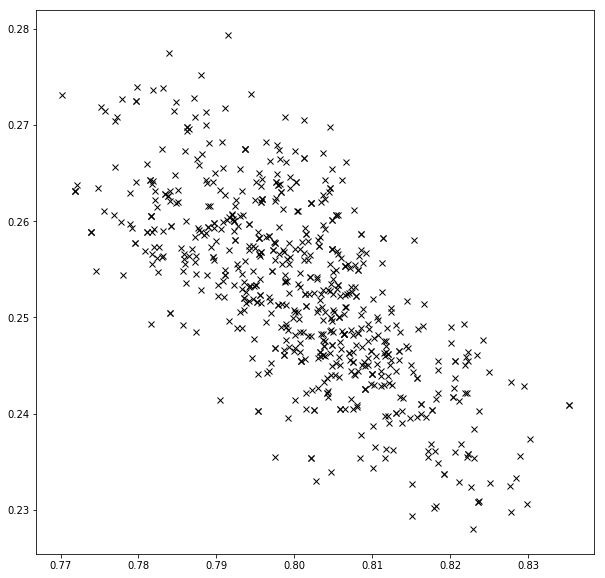

In [59]:
figure(figsize=(10,10))
chain = onp.array(sampler.trace)
i=0
j=1
# plot_contours(F, fid_params, i, j, facecolor='w', edgecolor='b')
# for k in range(845):
#     path = onp.array(sampler.paths[k*steps_per_iteration:(k+1)*steps_per_iteration])
#     if sampler.trace_accept[k]:
# #         plot(path[:, i], path[:, j], '-', alpha=0.1)
#         plot(chain[k, i], chain[k, j], 'kx')
plot(chain[:, i], chain[:, j], 'kx')

Text(0.5, 1.0, 'Get a load of this autocorrelation')

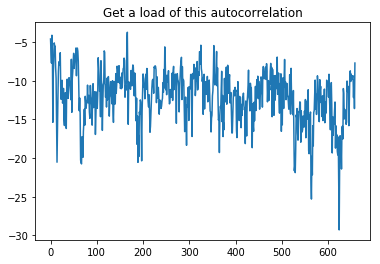

In [60]:
plot(sampler.trace_logP)
title("Get a load of this autocorrelation")

In [151]:
limits


[(0.5, 0.9),
 (0.1, 0.5),
 (0.03, 0.06),
 (0.5, 0.9),
 (0.9, 1.05),
 (-2.0, -0.5),
 (-0.06, 0.06),
 (-0.06, 0.06),
 (-0.06, 0.06),
 (-0.06, 0.06),
 (-0.1, 0.1),
 (-0.1, 0.1),
 (-0.1, 0.1),
 (-0.1, 0.1),
 (0.0, 3.0),
 (-3.0, 3.0)]

sigma8 sigma8
sigma8 Omega_c
sigma8 Omega_b
sigma8 h
sigma8 n_s
sigma8 w0
sigma8 m1
sigma8 m2
sigma8 m3
sigma8 m4
sigma8 dz1
sigma8 dz2
sigma8 dz3
sigma8 dz4
sigma8 A
sigma8 eta
sigma8 b1
sigma8 b2
sigma8 b3
sigma8 b4
sigma8 b5
Omega_c sigma8
Omega_c Omega_c
Omega_c Omega_b
Omega_c h
Omega_c n_s
Omega_c w0
Omega_c m1
Omega_c m2
Omega_c m3
Omega_c m4
Omega_c dz1
Omega_c dz2
Omega_c dz3
Omega_c dz4
Omega_c A
Omega_c eta
Omega_c b1
Omega_c b2
Omega_c b3
Omega_c b4
Omega_c b5
Omega_b sigma8
Omega_b Omega_c
Omega_b Omega_b
Omega_b h
Omega_b n_s
Omega_b w0
Omega_b m1
Omega_b m2
Omega_b m3
Omega_b m4
Omega_b dz1
Omega_b dz2
Omega_b dz3
Omega_b dz4
Omega_b A
Omega_b eta
Omega_b b1
Omega_b b2
Omega_b b3
Omega_b b4
Omega_b b5
h sigma8
h Omega_c
h Omega_b
h h
h n_s
h w0
h m1
h m2
h m3
h m4
h dz1
h dz2
h dz3
h dz4
h A
h eta
h b1
h b2
h b3
h b4
h b5
n_s sigma8
n_s Omega_c
n_s Omega_b
n_s h
n_s n_s
n_s w0
n_s m1
n_s m2
n_s m3
n_s m4
n_s dz1
n_s dz2
n_s dz3
n_s dz4
n_s A
n_s eta
n_s b1
n_s b2
n_s b3


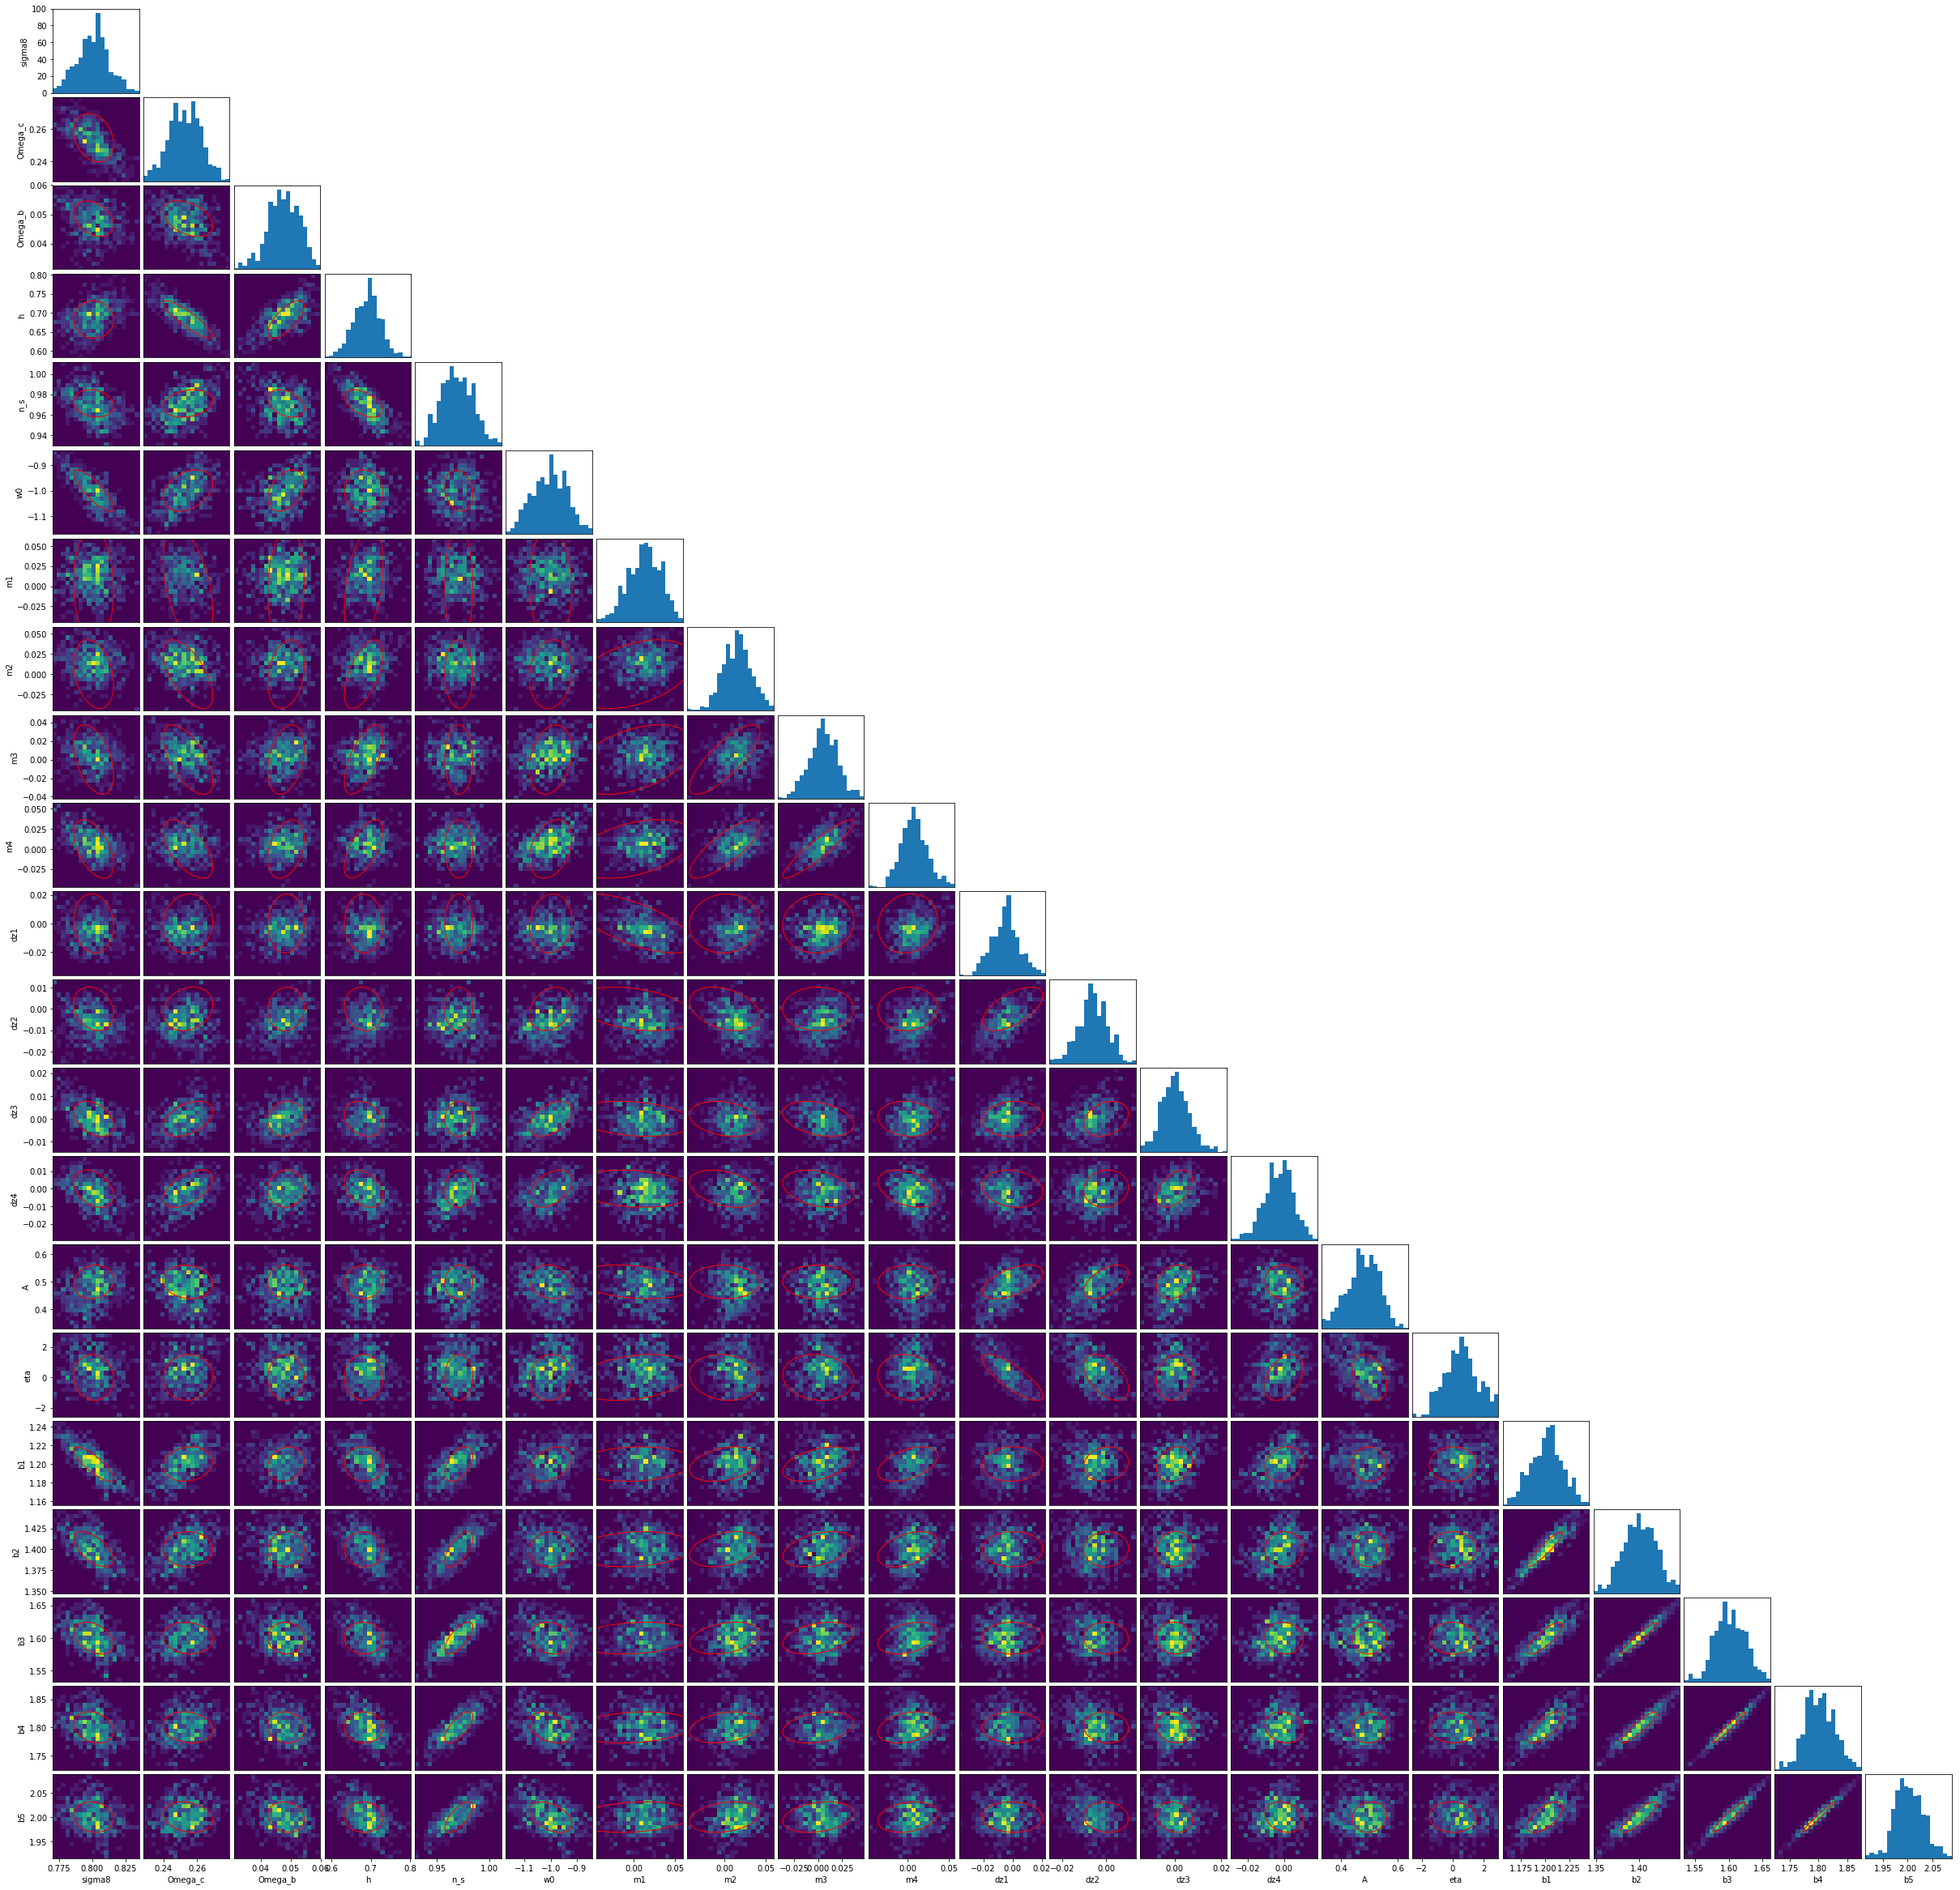

In [68]:
nparam = len(names)
nplot = nparam
fig, axes = plt.subplots(nplot, nplot, figsize=(2*nplot,2*nplot), sharex=False, sharey=False)
pmin = chain.min(axis=0)
pmax = chain.max(axis=0)
for i, name1 in enumerate(names[:]):
    for j, name2 in enumerate(names[:]):
        if i>=nplot or j >= nplot:
            continue
        print(name1, name2)
        ax = axes[i, j]
        if i < j:
            fig.delaxes(ax)
            continue
        if i == j:
            ax.hist(chain[:, i], bins=20)
            ax.set_xlim(pmin[i], pmax[i])
        else:
            ax.hist2d(chain[:, j], chain[:, i], bins=20)
            plot_contours(F, fid_params, j, i, ax=ax, edgecolor='r', facecolor='none')
            ax.set_xlim(pmin[j], pmax[j])
            ax.set_ylim(pmin[i], pmax[i])
        if j == 0:
            ax.set_ylabel(name1)
        else:
            ax.get_yaxis().set_visible(False)

        if i == nplot-1:
            ax.set_xlabel(name2)
        else:
            ax.get_xaxis().set_visible(False)
subplots_adjust(wspace=0.05)
subplots_adjust(hspace=0.05)
# Expand for many plots

In [69]:
savefig("corner.png")

<Figure size 432x288 with 0 Axes>

In [65]:
onp.savetxt("chain.txt", chain)

In [70]:
!open .


In [73]:
sampler2 = hmc.HMC(fun, M_inv, epsilon, steps_per_iteration, limits, kwargs=fun_kwargs)
%time sampler2.sample(1, fid_params)

U=2.252   T=7.756   H=10.008   ΔH=0.000
U=2.227   T=7.781   H=10.008   ΔH=-0.000
U=2.209   T=7.799   H=10.008   ΔH=0.000
U=2.199   T=7.809   H=10.008   ΔH=0.000
U=2.198   T=7.810   H=10.009   ΔH=0.001
U=2.207   T=7.802   H=10.009   ΔH=0.001
U=2.225   T=7.783   H=10.009   ΔH=0.001
U=2.259   T=7.753   H=10.013   ΔH=0.005
U=2.302   T=7.712   H=10.014   ΔH=0.006
U=2.360   T=7.657   H=10.017   ΔH=0.009
U=2.429   T=7.590   H=10.020   ΔH=0.012
U=2.509   T=7.510   H=10.020   ΔH=0.012
U=2.602   T=7.417   H=10.020   ΔH=0.012
U=2.713   T=7.311   H=10.024   ΔH=0.016
U=2.832   T=7.192   H=10.024   ΔH=0.016
U=2.964   T=7.060   H=10.024   ΔH=0.017
U=3.113   T=6.917   H=10.029   ΔH=0.021
U=3.257   T=6.762   H=10.019   ΔH=0.011
U=3.424   T=6.597   H=10.020   ΔH=0.012
U=3.601   T=6.422   H=10.023   ΔH=0.015
U=3.772   T=6.240   H=10.011   ΔH=0.004
U=3.961   T=6.051   H=10.012   ΔH=0.004
U=4.155   T=5.856   H=10.012   ΔH=0.004
U=4.354   T=5.658   H=10.012   ΔH=0.004
U=4.558   T=5.458   H=10.016   ΔH=0.008

In [74]:
chain.shape

(659, 21)